# Data loading, cleaning amd exploration

We start with adding packages that we need for the task of data exploration. 

In [193]:
!pip install pandas
!pip install .\pycld2-0.41-cp39-cp39-win_amd64.whl
!pip install langdetect
!pip install matplotlib
!pip install pywsd
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install tmtoolkit
!pip install gensim
!pip install pyLDAvis

Processing c:\users\elina\documents\radboud\masters\research-internship\pycld2-0.41-cp39-cp39-win_amd64.whl
pycld2 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
   ---------------------------------------- 0.0/96.6 kB ? eta -:--:--
   ---------------------------------------- 96.6/96.6 kB 5.4 MB/s eta 0:00:00
Using cached setuptools-69.2.0-py3-none-any.whl (821 kB)


In [212]:
import sys
sys.path.append(os.path.join(sys.path[0], 'internship-env', 'Lib', 'site-packages'))

import os, glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

import langdetect
import pycld2 as cld2

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pywsd
from pywsd.utils import lemmatize_sentence
from wordcloud import WordCloud, STOPWORDS

# LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA evaluation
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

#pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pyLDAvis.enable_notebook()

#NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.probability import MLEProbDist
from nltk.stem import WordNetLemmatizer

# Define stop words
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
devgpt_location = "./DevGPT/"
github_devgpt_snapshot_folders = [path for path,_,_ in os.walk(devgpt_location) if "snapshot" in path]
commits_json_filepaths = []
issues_json_filepaths = []
discussion_json_filepaths = []
pull_requests_json_filepaths = []
code_json_filepaths = []
hackernews_json_filepaths = []
for snapshot_folder in github_devgpt_snapshot_folders:
    json_file_paths = glob.glob(f'{snapshot_folder}/*.json')
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "file" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_paths}' was not recognised!")

""" Uncomment to print out all the file paths!
print(commits_json_filepaths)
print(issues_json_filepaths)
print(discussion_json_filepaths)
print(pull_requests_json_filepaths)
print(code_json_filepaths)
print(hackernews_json_filepaths)
"""

We start with looking closely at what data is contained in the files and whether newer snapshots were just appended with new information, but contain old snapshot information as well, or they just contain information that was created after the last snapshot was combined. 

In [8]:
# ========================= Columns =========================
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message', 'AuthorAt', 'CommitAt']
code_file_columns = ['Type', 'URL', 'ObjectSha', 'FileName', 'FilePath', 'Author', 'Content', 'RepoName', 'RepoLanguage', 'CommitSha', 'CommitMessage', 'AuthorAt', 'CommitAt']
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State']
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']
hacker_news_columns = ['Type', 'ID', 'URL', 'Author', 'Points', 'AttachedURL', 'Title', 'StoryText', 'CreatedAt', 'CommentsTotalCount']
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount']
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount']
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in commit_columns]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in code_file_columns]
    return code_files_array_of_elements

def process_issue_json(issue):
    issue_array_of_elements = [issue[col] if (col in issue) else "" for col in issue_columns]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] if (col in pull_request) else "" for col in pull_request_columns]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in hacker_news_columns]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] if (col in discussion) else "" for col in discussion_columns]
    return discussion_array_of_elements

def process_sharing_json(sharing):
    gptsharing_array_of_elements = [sharing['URL']]
    gptsharing_array_of_elements += [sharing[col] for col in gpt_sharing_columns[1:]]
    mention = sharing['Mention']
    gptsharing_array_of_elements += [mention[col] if (col in mention) else "" for col in mention_columns]
    return gptsharing_array_of_elements

In [9]:
def read_json_data_from_files_to_dataframe(filepaths_list):
    file_sharings_df = pd.DataFrame()
    for json_filepath in filepaths_list:
        with open(json_filepath, 'r') as file:
            # Load JSON data from file
            json_data = json.load(file)
            data_to_df = []
            for source in json_data['Sources']:
                source_array = []
                columns_for_df = []
                if source['Type'] == 'commit':
                    source_array = process_commit_json(source)
                    columns_for_df = commit_columns
                elif source['Type'] == 'code file':
                    source_array = process_code_files_json(source)
                    columns_for_df = code_file_columns
                elif source['Type'] == 'issue':
                    source_array = process_issue_json(source)
                    columns_for_df = issue_columns
                elif source['Type'] == 'pull request':
                    source_array = process_pull_request_json(source)
                    columns_for_df = pull_request_columns
                elif source['Type'] == 'hacker news':
                    source_array = process_hacker_news_json(source)
                    columns_for_df = hacker_news_columns
                elif source['Type'] == 'discussion':
                    source_array = process_discussion_json(source)
                    columns_for_df = discussion_columns
                else:
                    print(f"Unexpected type of the course: '{source['Type']}'")
                    raise
                for sharing in source['ChatgptSharing']:
                    if sharing['Status'] != 200:
                        continue
                    sharing_array = process_sharing_json(sharing)
                    data_to_df.append(source_array + sharing_array)
            file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df + gpt_sharing_columns + mention_columns)
            print(f"Data from '{json_filepath}' file contains {len(file_dataframe)} elements.")
            file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    print(f"When all the dataframes were concatenated/appended, we have total of {len(file_sharings_df)} rows in the DF.")
    file_sharings_df = file_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last') # Keep newest
    print(f"After removing the duplicated based on ChatGPT URL of the source, we have total of {len(file_sharings_df)} rows in the DF.")
    return file_sharings_df

In [10]:
commits_dataframe = read_json_data_from_files_to_dataframe(commits_json_filepaths)
commits_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200003_commit_sharings.json' file contains 178 elements.
Data from './DevGPT/snapshot_20230803\20230803_095317_commit_sharings.json' file contains 214 elements.
Data from './DevGPT/snapshot_20230810\20230810_124807_commit_sharings.json' file contains 301 elements.
Data from './DevGPT/snapshot_20230817\20230817_131244_commit_sharings.json' file contains 198 elements.
Data from './DevGPT/snapshot_20230824\20230824_102435_commit_sharings.json' file contains 199 elements.
Data from './DevGPT/snapshot_20230831\20230831_063412_commit_sharings.json' file contains 477 elements.
Data from './DevGPT/snapshot_20230907\20230907_110036_commit_sharings.json' file contains 398 elements.
Data from './DevGPT/snapshot_20230914\20230914_083202_commit_sharings.json' file contains 568 elements.
Data from './DevGPT/snapshot_20231012\20231012_230826_commit_sharings.json' file contains 692 elements.
When all the dataframes were concatenated/appended, we have tota

,Type,URL,Author,RepoName,RepoLanguage,Sha,Message,AuthorAt,CommitAt,SharingURL,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
7,commit,https://github.com/Hamza-Eng/baldie/commit/3a7...,Hamza-Eng,Hamza-Eng/baldie,Blade,3a7364f2ab5e67c80aa4f61f644f315e4b233390,add facebook pixel\n\nfor more information you...,2023-07-21T12:18:17.000+01:00,2023-07-21T12:18:17.000+01:00,https://chat.openai.com/share/e6c824b7-bf94-4b...,...,2097,,"[{'Prompt': 'add facebook pixel to laravel ', ...",https://github.com/Hamza-Eng/baldie/commit/3a7...,message,Hamza-Eng,add facebook pixel\n\nfor more information you...,,,
19,commit,https://github.com/jdustinwilliams/hibddbs/com...,dzdn,jdustinwilliams/hibddbs,CSS,e6a01ec078e950a277e7caa21affd7c4ae23d244,Make advanced search concise\n\nUsed ChatGPT f...,2023-08-22T14:09:17.000-04:00,2023-08-22T14:09:17.000-04:00,https://chat.openai.com/share/e476a2d0-5c29-4c...,...,1067,Default,[{'Prompt': 'Is there a way I could make this ...,https://github.com/jdustinwilliams/hibddbs/com...,message,dzdn,Make advanced search concise\n\nUsed ChatGPT f...,,,
0,commit,https://github.com/grnpin/textbox/commit/fa335...,grnpin,grnpin/textbox,HTML,fa335cf2ec447d00f8e94b54a8b463725b92947c,https://chat.openai.com/share/4bad57dd-9636-4b...,2023-09-20T21:02:53.000+09:00,2023-09-20T21:02:53.000+09:00,https://chat.openai.com/share/4bad57dd-9636-4b...,...,556,Default (GPT-3.5),[{'Prompt': 'このコードだと、スマートフォンでキーボードを表示したときにbutt...,https://github.com/grnpin/textbox/commit/fa335...,message,grnpin,https://chat.openai.com/share/4bad57dd-9636-4b...,,,
1,commit,https://github.com/grnpin/textbox/commit/0dfc4...,grnpin,grnpin/textbox,HTML,0dfc4385b723060e1e6a21da17a952bd908084ff,https://chat.openai.com/share/1fd7ffc2-9264-45...,2023-09-09T09:36:16.000+09:00,2023-09-09T09:36:16.000+09:00,https://chat.openai.com/share/1fd7ffc2-9264-45...,...,160,Default,[{'Prompt': 'このコードなんですが、Placeholder上でちゃんと改行するコ...,https://github.com/grnpin/textbox/commit/0dfc4...,message,grnpin,https://chat.openai.com/share/1fd7ffc2-9264-45...,,,
2,commit,https://github.com/grnpin/textbox/commit/811d0...,grnpin,grnpin/textbox,HTML,811d09acdca361c81281c7d71587ebdbd8437453,https://chat.openai.com/share/99d2d02f-7e3b-43...,2023-09-07T13:19:54.000Z,2023-09-07T13:19:54.000Z,https://chat.openai.com/share/99d2d02f-7e3b-43...,...,115,Default,[{'Prompt': 'refactor this code. <!DOCTYPE ht...,https://github.com/grnpin/textbox/commit/811d0...,message,grnpin,https://chat.openai.com/share/99d2d02f-7e3b-43...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,d0a54935a6e665bfaaa858adb6afc42b231707fe,Add more stuff to look at. (#7)\n\nhttps://cha...,2023-07-03T11:52:29.000-07:00,2023-07-03T11:52:29.000-07:00,https://chat.openai.com/share/b53e39ef-0e39-40...,...,1429,GPT-4,[{'Prompt': 'ok the console errors are gone bu...,https://github.com/hoshotakamoto/banzukesurfin...,message,hoshotakamoto,Add more stuff to look at. (#7)\n\nhttps://cha...,,,
688,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,90e1d68ddc8d3a2caa076ee4d423484bf0a742f3,Refactoring for interactivity. (#8)\n\nhttps:/...,2023-07-03T15:24:54.000-07:00,2023-07-03T15:24:54.000-07:00,https://chat.openai.com/share/76d4817d-40b6-4f...,...,2519,GPT-4,[{'Prompt': 'None of the localStorage stuff re...,https://github.com/hoshotakamoto/banzukesurfin...,message,hoshotakamoto,Refactoring for interactivity. (#8)\n\nhttps:/...,,,
689,commit,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,HTML,63b2ab90b0b138e509e87efad59fd72b414d0133,Incorporate local storage to put some state in...,2023-07-03T00:34:43.000-07:00,2023-07-03T00:34:43.000-07:00,https://chat.openai.com/share/b57df6eb-4eea-44...,...,3

In [11]:
issues_dataframe = read_json_data_from_files_to_dataframe(issues_json_filepaths)
issues_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195941_issue_sharings.json' file contains 243 elements.
Data from './DevGPT/snapshot_20230803\20230803_094705_issue_sharings.json' file contains 264 elements.
Data from './DevGPT/snapshot_20230810\20230810_123938_issue_sharings.json' file contains 306 elements.
Data from './DevGPT/snapshot_20230817\20230817_130502_issue_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20230824\20230824_101836_issue_sharings.json' file contains 369 elements.
Data from './DevGPT/snapshot_20230831\20230831_061759_issue_sharings.json' file contains 384 elements.
Data from './DevGPT/snapshot_20230907\20230907_092956_issue_sharings.json' file contains 419 elements.
Data from './DevGPT/snapshot_20230914\20230914_080417_issue_sharings.json' file contains 503 elements.
Data from './DevGPT/snapshot_20231012\20231012_235128_issue_sharings.json' file contains 598 elements.
When all the dataframes were concatenated/appended, we have total of 3416

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
11,issue,https://github.com/relaycorp/terraform-google-...,gnarea,relaycorp/terraform-google-awala-endpoint,HCL,4,Run bootstrapping job automatically every time...,See:\r\n\r\n- https://chat.openai.com/share/71...,,None,...,694,Default,[{'Prompt': 'I'm using Terraform to manage som...,https://github.com/relaycorp/terraform-google-...,body,gnarea,See:\r\n\r\n- https://chat.openai.com/share/71...,,,
157,issue,https://github.com/ookunirina/my_cinema_record...,ookunirina,ookunirina/my_cinema_record,Ruby,60,TMDb APIを使い投稿作成時のタイトル部分をオートコンプリートにする方法,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,None,...,1161,Default,[{'Prompt': '貴方は、Ruby on Railsでアプリ制作をする初心者エンジニ...,https://github.com/ookunirina/my_cinema_record...,body,ookunirina,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,,
119,issue,https://github.com/mostypc123/XediX/issues/6,mostypc123,mostypc123/XediX,Python,6,Firebase,How to connect Python to Firebase?,,2023-08-14T14:47:48Z,...,228,Default,[{'Prompt': 'Can I connect Firebase to my Pyth...,https://github.com/mostypc123/XediX/issues/6#i...,comments.body,mostypc123,"Completed, AI says me how to connect it. Chat:...",,,
29,issue,https://github.com/yeu-github/model/issues/1,yeu-github,yeu-github/model,None,1,melih,--,,None,...,3833,Default,[{'Prompt': 'euler acısını gorsellestiren bir ...,https://github.com/yeu-github/model/issues/1#i...,comments.body,yeu-github,https://chat.openai.com/share/0b1cd1fb-57e0-41...,,,
69,issue,https://github.com/CodeConnoisseur74/pdi-to-do...,bbelderbos,CodeConnoisseur74/pdi-to-do-list,Python,2,add a persistence layer,we can try sqlmodel (I will send you a customi...,,None,...,1996,Default,[{'Prompt': 'how to best explain sqlmodel to a...,https://github.com/CodeConnoisseur74/pdi-to-do...,comments.body,bbelderbos,@CodeConnoisseur74 I made this customized tuto...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,issue,https://github.com/ioccc-src/mkiocccentry/issu...,xexyl,ioccc-src/mkiocccentry,C,723,Question: Issues that aren’t really major issu...,Due to the fact that we have another issue tha...,,None,...,310,Default (GPT-3.5),[{'Prompt': 'Identify the quote: My precious. ...,https://github.com/ioccc-src/mkiocccentry/issu...,comments.body,xexyl,And as for the link to the other chat: https:/...,,,
594,issue,https://github.com/jasonacox/Powerwall-Dashboa...,aesculus,jasonacox/Powerwall-Dashboard,Python,288,Install On QNAP NAS with Graphana Port Change,I am making some progress on getting the dashb...,,2023-07-21T16:19:27Z,...,448,Default (GPT-3.5),[{'Prompt': 'Using docker compose I get the fo...,https://github.com/jasonacox/Powerwall-Dashboa...,comments.body,jasonacox,That's fantastic @aesculus ! Great progress.\...,,,
595,issue,https://github.com/MatrixAI/js-mdns/issues/1,joshuakarp,MatrixAI/js-mdns,TypeScript,1,Local Network Traversal - Multicast Discovery,_Created by @CMCDragonkai_ \r\n### Specificati...,,2023-07-24T07:37:55Z,...,6728,GPT-4,"[{'Prompt': 'In Linux, when you attach an ethe...",https://github.com/MatrixAI/js-mdns/issues/1#i...,comments.body,CMCDragonkai,Some relevant discussion about sockets and int...,,,
596,issue,https://github.com/open-spaced-repetition/fsrs...,L-M-Sherlock,open-spaced-repetition/fsrs4anki,Jupyter Notebook,351,[Doc] Introduction for FSRS v4,1) Re-writing the wiki. I suggest opening a ne...,,2023-09-20T15:56:42Z,...,1110,Plugins,"[{'Prompt': 'You are a professional explainer,...",https://github.com/open-spaced-repetition/fsrs...,comments.body,L-M-Sherlock,> These opinions and suggestions cover various...,,,


In [12]:
discussions_dataframe = read_json_data_from_files_to_dataframe(discussion_json_filepaths)
discussions_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195954_discussion_sharings.json' file contains 33 elements.
Data from './DevGPT/snapshot_20230803\20230803_094811_discussion_sharings.json' file contains 35 elements.
Data from './DevGPT/snapshot_20230810\20230810_124048_discussion_sharings.json' file contains 38 elements.
Data from './DevGPT/snapshot_20230817\20230817_130721_discussion_sharings.json' file contains 43 elements.
Data from './DevGPT/snapshot_20230824\20230824_102000_discussion_sharings.json' file contains 45 elements.
Data from './DevGPT/snapshot_20230831\20230831_061926_discussion_sharings.json' file contains 46 elements.
Data from './DevGPT/snapshot_20230907\20230907_093129_discussion_sharings.json' file contains 50 elements.
Data from './DevGPT/snapshot_20230914\20230914_080601_discussion_sharings.json' file contains 55 elements.
Data from './DevGPT/snapshot_20231012\20231012_235320_discussion_sharings.json' file contains 61 elements.
When all the dataframes were concaten

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,discussion,https://github.com/xihajun/Projects/discussions/3,xihajun,xihajun/Projects,Jupyter Notebook,3,ONNX model,学习ONNX： https://chat.openai.com/share/f868e43e...,,None,...,2204,Advanced Data Analysis,[{'Prompt': '什么是ONNX模型？我是一名新生，您是世界上最好的老师，也是最优秀...,https://github.com/xihajun/Projects/discussions/3,body,xihajun,学习ONNX： https://chat.openai.com/share/f868e43e...,,,
1,discussion,https://github.com/vueuse/vueuse/discussions/3355,bobmulder,vueuse/vueuse,TypeScript,3355,An utility method to trigger a function when s...,"Hi all,\r\n\r\nI have a usecase where I want t...",,None,...,428,Default (GPT-3.5),[{'Prompt': 'I have a vue 3 application. I hav...,https://github.com/vueuse/vueuse/discussions/3355,body,bobmulder,"Hi all,\r\n\r\nI have a usecase where I want t...",,,
2,discussion,https://github.com/huangyinhaow/blogGiscus/dis...,giscus,huangyinhaow/blogGiscus,None,11,屠呦呦：跨界者还是守界者？,# 屠呦呦：跨界者还是守界者？\n\n探讨屠呦呦：她是跨界者还是守界者？\n\nhttps:...,,None,...,1158,Default (GPT-3.5),[{'Prompt': '使以下文章更有逻辑性 屠呦呦究竟是跨界者还是守界者 时光如白驹...,https://github.com/huangyinhaow/blogGiscus/dis...,comments.body,huangyinhaow,https://chat.openai.com/share/9495ba64-83ce-41...,,,1
3,discussion,https://github.com/git-lfs/git-lfs/discussions...,ggrrll,git-lfs/git-lfs,Go,5457,documentation on reverting / untracking,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,None,...,533,Default (GPT-3.5),[{'Prompt': ' migrate back to git files tracke...,https://github.com/git-lfs/git-lfs/discussions...,body,ggrrll,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,,
4,discussion,https://github.com/prgrms-fe-devcourse/FEDC4_H...,jkea1,prgrms-fe-devcourse/FEDC4_HONKOK_JunilHwang,TypeScript,47,랜덤한 id 생성하기,id 생성을 라이브러리 사용을 안하고 커스텀 함수로 만든다고 들었던거 같은데 내일 ...,,None,...,281,Default (GPT-3.5),[{'Prompt': '자바스크립트로 랜덤한 id를 생성하는 함수 코드를 알려줘.'...,https://github.com/prgrms-fe-devcourse/FEDC4_H...,comments.body,jgjgill,gpt에 물어봤습니다..!\r\nhttps://chat.openai.com/shar...,,,1
5,discussion,https://github.com/orgs/community/discussions/...,eightnoteight,community/community,Ruby,62307,Copilot generating only one line at a time,### Select Topic Area\n\nQuestion\n\n### Body\...,,None,...,407,Default (GPT-3.5),[{'Prompt': 'generate missing code in the belo...,https://github.com/orgs/community/discussions/...,body,eightnoteight,### Select Topic Area\n\nQuestion\n\n### Body\...,,,
7,discussion,https://github.com/orgs/deep-foundation/discus...,FreePhoenix888,deep-foundation/Discussions,None,27,Should we worry about imports perfomance in ha...,My dialogue with chatgpt about it: https://cha...,,None,...,413,GPT-4,[{'Prompt': 'Can I always use await import ins...,https://github.com/orgs/deep-foundation/discus...,body,FreePhoenix888,My dialogue with chatgpt about it: https://cha...,,,
8,discussion,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,JushBJJ,JushBJJ/Mr.-Ranedeer-AI-Tutor,None,74,v2.7 - Code Interpreter Exclusive,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,None,...,315,Advanced Data Analysis,"[{'Prompt': '=== Author: JushBJJ Name: ""Mr. Ra...",https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,body,JushBJJ,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,,
9,discussion,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,JushBJJ,JushBJJ/Mr.-Ranedeer-AI-Tutor,None,74,v2.7 - Code Interpreter Exclusive,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,None,...,91,Default (GPT-3.5),[{'Prompt': '[Personalization Options] Lan...,https://github.com/JushBJJ/Mr.-Ranedeer-AI-Tut...,body,JushBJJ,# Mr. Ranedeer v2.7 - Code Interpreter Exclusi...,,,
10,discussion,https://github.com/clojure-emacs/cider/discuss...,vemv,clojure-emacs/cider,Emacs Lisp,3391,CiderGPT,"A clojure-specific ""gpt mode"" would seem nice ...",,None,...,122,GPT-4,[{'Prompt': 'Please assume the role of a Cloju...

In [13]:
pull_requests_dataframe = read_json_data_from_files_to_dataframe(pull_requests_json_filepaths)
pull_requests_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195927_pr_sharings.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230803\20230803_093947_pr_sharings.json' file contains 166 elements.
Data from './DevGPT/snapshot_20230810\20230810_123110_pr_sharings.json' file contains 175 elements.
Data from './DevGPT/snapshot_20230817\20230817_125147_pr_sharings.json' file contains 184 elements.
Data from './DevGPT/snapshot_20230824\20230824_100450_pr_sharings.json' file contains 197 elements.
Data from './DevGPT/snapshot_20230831\20230831_060603_pr_sharings.json' file contains 208 elements.
Data from './DevGPT/snapshot_20230907\20230907_091631_pr_sharings.json' file contains 220 elements.
Data from './DevGPT/snapshot_20230914\20230914_074826_pr_sharings.json' file contains 231 elements.
Data from './DevGPT/snapshot_20231012\20231012_233628_pr_sharings.json' file contains 286 elements.
When all the dataframes were concatenated/appended, we have total of 1827 rows in the DF.
After remo

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
2,pull request,https://github.com/nestoca/actions/pull/29,felleg,nestoca/actions,Go,29,feat(devops-1790): create reusable action to p...,Questions left to answer:\r\n\r\n- To do my do...,2023-08-02T19:36:31Z,None,...,4455,,[{'Prompt': 'i want to create a github action ...,https://github.com/nestoca/actions/pull/29,body,felleg,Questions left to answer:\r\n\r\n- To do my do...,,,
91,pull request,https://github.com/nestoca/actions/pull/30,alexstojda,nestoca/actions,Go,30,feat(DEVOPS-1846): monorepo - Auto-promote PR ...,,2023-08-11T00:19:44Z,2023-08-15T21:04:38Z,...,416,Default,"[{'Prompt': 'In github actions, I have this co...",https://github.com/nestoca/actions/pull/30#dis...,reviews.body,silphid,Was wondering whether we could make this more ...,build-monorepo-app/action.yaml,,
67,pull request,https://github.com/n-koga96/practice-React-exa...,n-koga96,n-koga96/practice-React-example-1,JavaScript,1,練習ブランチ１,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,2023-06-09T05:02:58Z,2023-07-11T03:40:40Z,...,5415,Default,[{'Prompt': '自分のmac PCにnode.jsが入っているかどうかを確かめるコ...,https://github.com/n-koga96/practice-React-exa...,body,n-koga96,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,,,
106,pull request,https://github.com/zhyunk/zb-mission-store-res...,zhyunk,zhyunk/zb-mission-store-reserve,Java,54,"#29 service , controller 정리",this closes #29,2023-08-02T18:11:46Z,2023-08-02T18:11:54Z,...,553,Default,"[{'Prompt': 'java에서 단일 객체를 반환하는 최종 연산자', 'Answ...",https://github.com/zhyunk/zb-mission-store-res...,reviews.body,zhyunk,최종 연산자\r\nhttps://chat.openai.com/share/db0905...,mission/src/main/java/kim/zhyun/mission/seller...,,
131,pull request,https://github.com/ubiquity/ubiquity-dollar/pu...,ghost,ubiquity/ubiquity-dollar,None,724,add the cspell in husky,Resolves #562 \r\n,2023-07-08T19:11:22Z,2023-07-09T13:35:08Z,...,747,Default,[{'Prompt': 'I have an active codebase with a ...,https://github.com/ubiquity/ubiquity-dollar/pu...,comments.body,molecula451,> https://chat.openai.com/share/084a9c22-efea-...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,pull request,https://github.com/openai/evals/pull/1083,AaronGoldsmith,openai/evals,C++,1083,[Eval] Viewport to grid size,# Thank you for contributing an eval! ♥️\r\n\r...,2023-06-02T02:53:27Z,2023-07-04T02:05:57Z,...,2892,GPT-4,[{'Prompt': 'I'm having trouble understanding ...,https://github.com/openai/evals/pull/1083,body,AaronGoldsmith,# Thank you for contributing an eval! ♥️\r\n\r...,,,
282,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,qryxip,VOICEVOX/voicevox_core,C++,532,ドキュメントを刷新する,## 内容\r\n\r\nRust/C/Python APIのドキュメントを刷新します。\r...,2023-06-25T14:03:16Z,2023-08-02T11:22:43Z,...,615,GPT-4,[{'Prompt': 'こちらの変更に対して、 - /// 与えられたパスからモデ...,https://github.com/VOICEVOX/voicevox_core/pull...,reviews.body,Hiroshiba,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,crates/voicevox_core/src/voice_model.rs,,
283,pull request,https://github.com/MatrixAI/Polykey/pull/552,CMCDragonkai,MatrixAI/Polykey,C++,552,Consolidating Configuration Entropy and Nodes ...,### Description\r\n\r\nThe configuration of Po...,2023-08-16T13:29:46Z,2023-10-04T06:03:18Z,...,286,GPT-4,[{'Prompt': 'Here is some rust code: ``` let ...,https://github.com/MatrixAI/Polykey/pull/552#i...,comments.body,CMCDragonkai,So simply because `maxIdleTimeout` has to be c...,,,
284,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,sevenc-nanashi,VOICEVOX/voicevox_core,C++,538,[vvm-async-api] Add: ユーザー辞書APIを追加,## 内容\r\n\r\nユーザー辞書を実装します。\r\n\r\n## 関連 Issue\...,2023-07-08T15:05:40Z,2023-07-22T14:01:36Z,...,319,Plugins,[{'Prompt': 'この2つの処理は一緒でしょうか？ const convertHa...,https://github.com/VOICEVOX/voicevox_core/pull...,reviews.body,Hiroshiba,ChatGPT君に違いを聞いてみたら

In [14]:
code_dataframe = read_json_data_from_files_to_dataframe(code_json_filepaths)
code_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200102_file_sharings.json' file contains 957 elements.
Data from './DevGPT/snapshot_20230803\20230803_103605_file_sharings.json' file contains 1052 elements.
Data from './DevGPT/snapshot_20230810\20230810_133121_file_sharings.json' file contains 1076 elements.
Data from './DevGPT/snapshot_20230817\20230817_151344_file_sharings.json' file contains 1047 elements.
Data from './DevGPT/snapshot_20230824\20230824_111114_file_sharings.json' file contains 1141 elements.
Data from './DevGPT/snapshot_20230831\20230831_072722_file_sharings.json' file contains 1306 elements.
Data from './DevGPT/snapshot_20230907\20230907_121304_file_sharings.json' file contains 1193 elements.
Data from './DevGPT/snapshot_20230914\20230914_104122_file_sharings.json' file contains 1184 elements.
Data from './DevGPT/snapshot_20231012\20231012_234250_file_sharings.json' file contains 2540 elements.
When all the dataframes were concatenated/appended, we have total of 11496

,Type,URL,ObjectSha,FileName,FilePath,Author,Content,RepoName,RepoLanguage,CommitSha,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
78,code file,https://github.com/howard9192/Promptgpt/blob/3...,1a115cfc7aec29606fb4149b7137f75d687ab40c,Instructions.md,Instructions.md,howard9192,IyBJbnN0YWxsYXRpb24gSW5zdHJ1Y3Rpb25zIPCfmoAKCl...,howard9192/Promptgpt,None,3bafe86771bead233aa8f968d944e45125693cce,...,351,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
79,code file,https://github.com/howard9192/Promptgpt/blob/3...,1a115cfc7aec29606fb4149b7137f75d687ab40c,Instructions.md,Instructions.md,howard9192,IyBJbnN0YWxsYXRpb24gSW5zdHJ1Y3Rpb25zIPCfmoAKCl...,howard9192/Promptgpt,None,3bafe86771bead233aa8f968d944e45125693cce,...,353,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
182,code file,https://github.com/mariolambrette/MResSW/blob/...,202d366b4c300a226c804935d8ff07dc48672ab1,YOLO_img_resize.R,emyolo/R/YOLO_img_resize.R,mariolambrette,IycgUmVzaXplIGFsbCBpbWFnZXMgaW4gYSBkaXJlY3Rvcn...,mariolambrette/MResSW,HTML,066479be09b9be7718137a395b091a1d44670bd6,...,567,Default,[{'Prompt': 'I have a large number of .jpg fil...,https://github.com/mariolambrette/MResSW/blob/...,code,mariolambrette,#' Resize all images in a directory\n#'\n#' Th...,,,
194,code file,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,211b38de6cb81ab3e24f72a953b507e920641d43,Resposta.txt,v2122-t2/src/main/kotlin/ex8/Resposta.txt,RicardoPinto26,VW1hIHJvb3QgcmVmZXJlbmNlIMOpIHVtYSBkYXMgcmVmZX...,RicardoPinto26/ISEL-LEIC-LAE-ALL_EXAM_SOLUTIONS,Java,03f1081077ff295b55532666b9207378f6daf667,...,411,Default,[{'Prompt': 'No contexto do Garbage Collector ...,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,code,RicardoPinto26,Uma root reference é uma das referencias base ...,,,
207,code file,https://github.com/baku67/ELAN_Projet_SquadFor...,021e85cb2be22bea567b56e48e845b1fc7b1acc9,tuto,Annexes/tuto,baku67,VE9ETyBkb3NzaXJ0CgpUcmVsbG8KTcOpdGhvZGUgTW9zb3...,baku67/ELAN_Projet_SquadForge,CSS,9a3e668e5f73d4974682989bed8d6b0d5f77f3f8,...,957,Default,[{'Prompt': 'Comment Facebook ou les autres ré...,https://github.com/baku67/ELAN_Projet_SquadFor...,code,baku67,TODO dossirt\n\nTrello\nMéthode Mosow (hierarc...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,code file,https://github.com/rumca-js/RSS-Link-Database-...,fa2dd24e0b9bd7f80327b45f0df9cbf17def47c9,https.hnrss.orgfrontpage_entries.md,2023/09/2023-09-09/https.hnrss.orgfrontpage_en...,rumca-js,IyBTb3VyY2U6SGFja2VyIE5ld3MgLSBmcm9udHBhZ2UsIF...,rumca-js/RSS-Link-Database-2023,HTML,0757d06e84d8c8c4adf97a2c73b384baf0b511be,...,394,GPT-4,[{'Prompt': 'Why doesn't Apple add cellular se...,https://github.com/rumca-js/RSS-Link-Database-...,code,rumca-js,"# Source:Hacker News - frontpage, URL:https://...",,,
2536,code file,https://github.com/theparticleman/theparticlem...,f3e7ef06a0f5238cb19de7983fa2c71bb3b317ba,can-chatgpt-do-test-driven-development.md,posts/can-chatgpt-do-test-driven-development.md,theparticleman,QSBmcmllbmQgb2YgbWluZSByZWNlbnRseSBwaW5nZWQgbW...,theparticleman/theparticleman.github.io,C#,69c4c61a61729c0ec73108f3e59e98623612539d,...,8781,Default (GPT-3.5),[{'Prompt': 'write code that converts arabic n...,https://github.com/theparticleman/theparticlem...,code,theparticleman,A friend of mine recently pinged me on LinkedI...,,,
2537,code file,https://github.com/thku8507/thku8507.github.io...,f6fb60acabee215263c83b55cf487384db789959,01-modis-ndvi.ipynb,Notebooks/01-modis-ndvi.ipynb,thku8507,ewogImNlbGxzIjogWwogIHsKICAgImNlbGxfdHlwZSI6IC...,thku8507/thku8507.github.io,HTML,d85f414af3435df66c9d7e5429bbcfd0ea1a83fa,...,560,Default

In [15]:
hackernews_dataframe = read_json_data_from_files_to_dataframe(hackernews_json_filepaths)
hackernews_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195816_hn_sharings.json' file contains 174 elements.
Data from './DevGPT/snapshot_20230803\20230803_105332_hn_sharings.json' file contains 191 elements.
Data from './DevGPT/snapshot_20230810\20230810_134011_hn_sharings.json' file contains 241 elements.
Data from './DevGPT/snapshot_20230817\20230817_170022_hn_sharings.json' file contains 267 elements.
Data from './DevGPT/snapshot_20230824\20230824_112153_hn_sharings.json' file contains 288 elements.
Data from './DevGPT/snapshot_20230831\20230831_073827_hn_sharings.json' file contains 293 elements.
Data from './DevGPT/snapshot_20230907\20230907_123434_hn_sharings.json' file contains 307 elements.
Data from './DevGPT/snapshot_20230914\20230914_105439_hn_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20231012\20231012_232232_hn_sharings.json' file contains 283 elements.
When all the dataframes were concatenated/appended, we have total of 2374 rows in the DF.
After remo

,Type,ID,URL,Author,Points,AttachedURL,Title,StoryText,CreatedAt,CommentsTotalCount,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,hacker news,37500887,https://news.ycombinator.com/item?id=37500887,gorenb,2.0,https://chat.openai.com/share/a7395106-b14e-47...,The Rust Evangelism Strike Force and Q-Anon: A...,None,2023-09-13T19:48:07.000Z,0,...,2915,Default,[{'Prompt': 'your feather tastes like a numeri...,https://news.ycombinator.com/item?id=37500887,url,gorenb,https://chat.openai.com/share/a7395106-b14e-47...,,,
1,hacker news,37494620,https://news.ycombinator.com/item?id=37494620,JonathanFly,336.0,https://stability.ai/research/stable-audio-eff...,Stable Audio: Fast Timing-Conditioned Latent A...,None,2023-09-13T10:00:00.000Z,28,...,120,Default,[{'Prompt': 'Show me 12 bars of chords for blu...,https://news.ycombinator.com/item?id=37497106,comment,viraptor,From what I've seen in the generated tracks so...,,,
2,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,1194,Default,[{'Prompt': 'Step into 🏯HISTORYLENS: Russian R...,https://news.ycombinator.com/item?id=37490574,comment,rastapasta42,What are your thoughts on this update? <a href...,,,
3,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,508,Default,[{'Prompt': '==== Text extracted from the Min...,https://news.ycombinator.com/item?id=37486524,comment,DonHopkins,Great idea!<p>Why leave hallucinations to chan...,,,
4,hacker news,37480155,https://news.ycombinator.com/item?id=37480155,arbesman,167.0,https://resobscura.substack.com/p/simulating-h...,Simulating History with ChatGPT,None,2023-09-12T12:34:40.000Z,15,...,502,Default,[{'Prompt': 'Please become 🏯HISTORYLENS: MING ...,https://news.ycombinator.com/item?id=37483815,comment,benbreen,"""I think it can be taken further; rather than ...",,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,860,GPT-4,[{'Prompt': 'You were advised the following to...,https://news.ycombinator.com/item?id=36091952,comment,BoorishBears,How imaginative do you consider this story: <a...,,,
279,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,323,GPT-4,[{'Prompt': 'Let's work this out in a step-by-...,https://news.ycombinator.com/item?id=36091686,comment,e1g,Seems to do fine if you instruct it to get to ...,,,
280,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,153,Web Browsing,[{'Prompt': 'Who is Obie Fernandez and what is...,https://news.ycombinator.com/item?id=36091476,comment,obiefernandez,"Vanity search in 2023 <a href=""https://chat.op...",,,
281,hacker news,36091388,https://news.ycombinator.com/item?id=36091388,obiefernandez,282.0,https://chat.openai.com/share/66169853-d00a-4b...,ChatGPT conversations can be shared publicly,None,2023-05-27T01:58:56.000Z,31,...,392,GPT-4,"[{'Prompt': 'What is Hacker News, what can you...",https://news.ycombinator.com/item?id=36091388,url,obiefernandez,https://chat.openai.com/share/66169853-d00a-4b...,,,


In [16]:


dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

for idx, dataframe in enumerate(dataframes):
    print(f"Dataframe {dataframe_names[idx]} elements before language check: {len(dataframe)}")
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        list_of_languages = []
        for conv in conversations:
            languages_2tuple = ("", "")
            reliable = False
            try:
                isReliable, textBytesFound, details = cld2.detect(conv['Prompt'])
                langdetect_lang = langdetect.detect(conv['Prompt'])
                cld2_lang = details[0][1]
                reliable = isReliable
                languages_2tuple = (langdetect_lang, cld2_lang)
            except:
                print(f"Language was not identified for prompt: {conv['Prompt']}")
            list_of_languages.append(languages_2tuple)
        most_common = max(set(list_of_languages), key = list_of_languages.count)
        if not (most_common == ('en', 'en') or most_common == ('un', 'en') or most_common == ('en', 'un')):
            dataframe.drop(index, inplace=True)
    print(f"Dataframe elements after language check: {len(dataframe)}")
    print("======================================================================================")

Dataframe commits elements before language check: 670
Language was not identified for prompt: This fails to remove the control chars added by zsh.

console.log(combinedData, cleanedData) logs:

[Jko@MacBook-Pro-5 Junior %  
Jko@MacBook-Pro-5 Junior % ?2004h

Fix this and use the same goal
Language was not identified for prompt: Plan:
1. Rename convert-svg-to-png.cjs to updateLogo.js
2. Refactor updateLogo.js to export single function and use ES6 imports and async/await
3. Update package.json script for update-logo to use the new script name
jq: error: logo/0 is not defined at <top-level>, line 1:
.scripts.update-logo = "node -r esm ./scripts/updateLogo.js"                
jq: 1 compile error
Done: Rename and refactor SVG to PNG converter

Also don't forget to delete the temp file
Also the project is configured for ES6, is -r needed?
Language was not identified for prompt: 1 + 1
Dataframe elements after language check: 660
Dataframe issues elements before language check: 516
Language wa

# Data exploration

In [73]:

dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

conversation_lengths, avg_prompt_lengths, avg_prompt_word_count = [], [], []

for df_idx in range(len(dataframes)):
    dataframe_conversation_lengths, dataframe_conversation_lengths_for_avg, dataframe_prompt_lengths_sum, dataframe_prompt_wordcounts_sum = [], [], [], []
    for index, df_row in dataframes[df_idx].iterrows():
        conversations = df_row["Conversations"]
        lengths = []
        conv_length = len(conversations)
        for conv_idx in range(len(conversations)):
            conversation = conversations[conv_idx]
            prompt = conversation['Prompt']
            prompt_len = len(prompt)
            prompt_word_count = len(prompt.split())
            if len(dataframe_conversation_lengths_for_avg) <= conv_idx:
                dataframe_conversation_lengths_for_avg.append(1)
            else:
                dataframe_conversation_lengths_for_avg[conv_idx] += 1
            if len(dataframe_prompt_lengths_sum) <= conv_idx:
                dataframe_prompt_lengths_sum.append(prompt_len)
            else:
                dataframe_prompt_lengths_sum[conv_idx] += prompt_len
            if len(dataframe_prompt_wordcounts_sum) <= conv_idx:
                dataframe_prompt_wordcounts_sum.append(prompt_word_count)
            else:
                dataframe_prompt_wordcounts_sum[conv_idx] += prompt_word_count
        dataframe_conversation_lengths.append(conv_length)
    conversation_lengths.append(dataframe_conversation_lengths)
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_lengths_sum))
    avg_prompt_lengths.append([dataframe_prompt_lengths_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))])
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_wordcounts_sum))
    avg_prompt_word_count.append([dataframe_prompt_wordcounts_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))])

conv_dictionary = []
conversation_count_per_conv_nr = [np.zeros(max(l)) for l in conversation_lengths]
for lengths in conversation_lengths:
    counts = dict()
    for i in lengths:
        counts[i] = counts.get(i, 0) + 1
        conversation_count_per_conv_nr[conversation_lengths.index(lengths)][:i] += 1
    conv_dictionary.append(counts)
conv_dictionary = [dict(sorted(df_dict.items())) for df_dict in conv_dictionary] # Sort

for indx in range(len(dataframes)):
    print(f"Statistics for {dataframe_names[indx]} dataframe:")
    print("Dictionary containing the count of the lengths of the conversations: ", conv_dictionary[indx])
    print("Average prompt lengths for each prompt: ", avg_prompt_lengths[indx])
    print("Average word count for each prompt: ", avg_prompt_word_count[indx])
    print("=============================================================================")

Statistics for commits dataframe:
Dictionary containing the count of the lengths of the conversations:  {1: 510, 2: 52, 3: 35, 4: 15, 5: 5, 6: 5, 7: 6, 8: 1, 9: 4, 10: 3, 11: 3, 13: 2, 14: 2, 15: 2, 16: 2, 17: 1, 19: 2, 20: 1, 21: 1, 24: 2, 25: 1, 26: 2, 29: 1, 33: 1, 63: 1}
Average prompt lengths for each prompt:  [2709.70303030303, 543.9466666666667, 477.2959183673469, 348.26984126984127, 327.0833333333333, 367.04651162790697, 434.8157894736842, 379.84375, 427.4516129032258, 644.6296296296297, 694.5, 580.7619047619048, 415.2857142857143, 629.5263157894736, 906.8823529411765, 136.0, 736.4615384615385, 291.3333333333333, 160.08333333333334, 95.6, 106.66666666666667, 137.875, 187.25, 167.5, 119.5, 125.4, 153.33333333333334, 47.333333333333336, 120.33333333333333, 44.5, 30.5, 29.0, 3746.0, 20.0, 39.0, 14.0, 28.0, 38.0, 12.0, 25.0, 10.0, 32.0, 32.0, 33.0, 14.0, 22.0, 21.0, 24.0, 24.0, 65.0, 62.0, 25.0, 18.0, 43.0, 169.0, 73.0, 30.0, 42.0, 139.0, 32.0, 52.0, 26.0, 51.0]
Average word count 

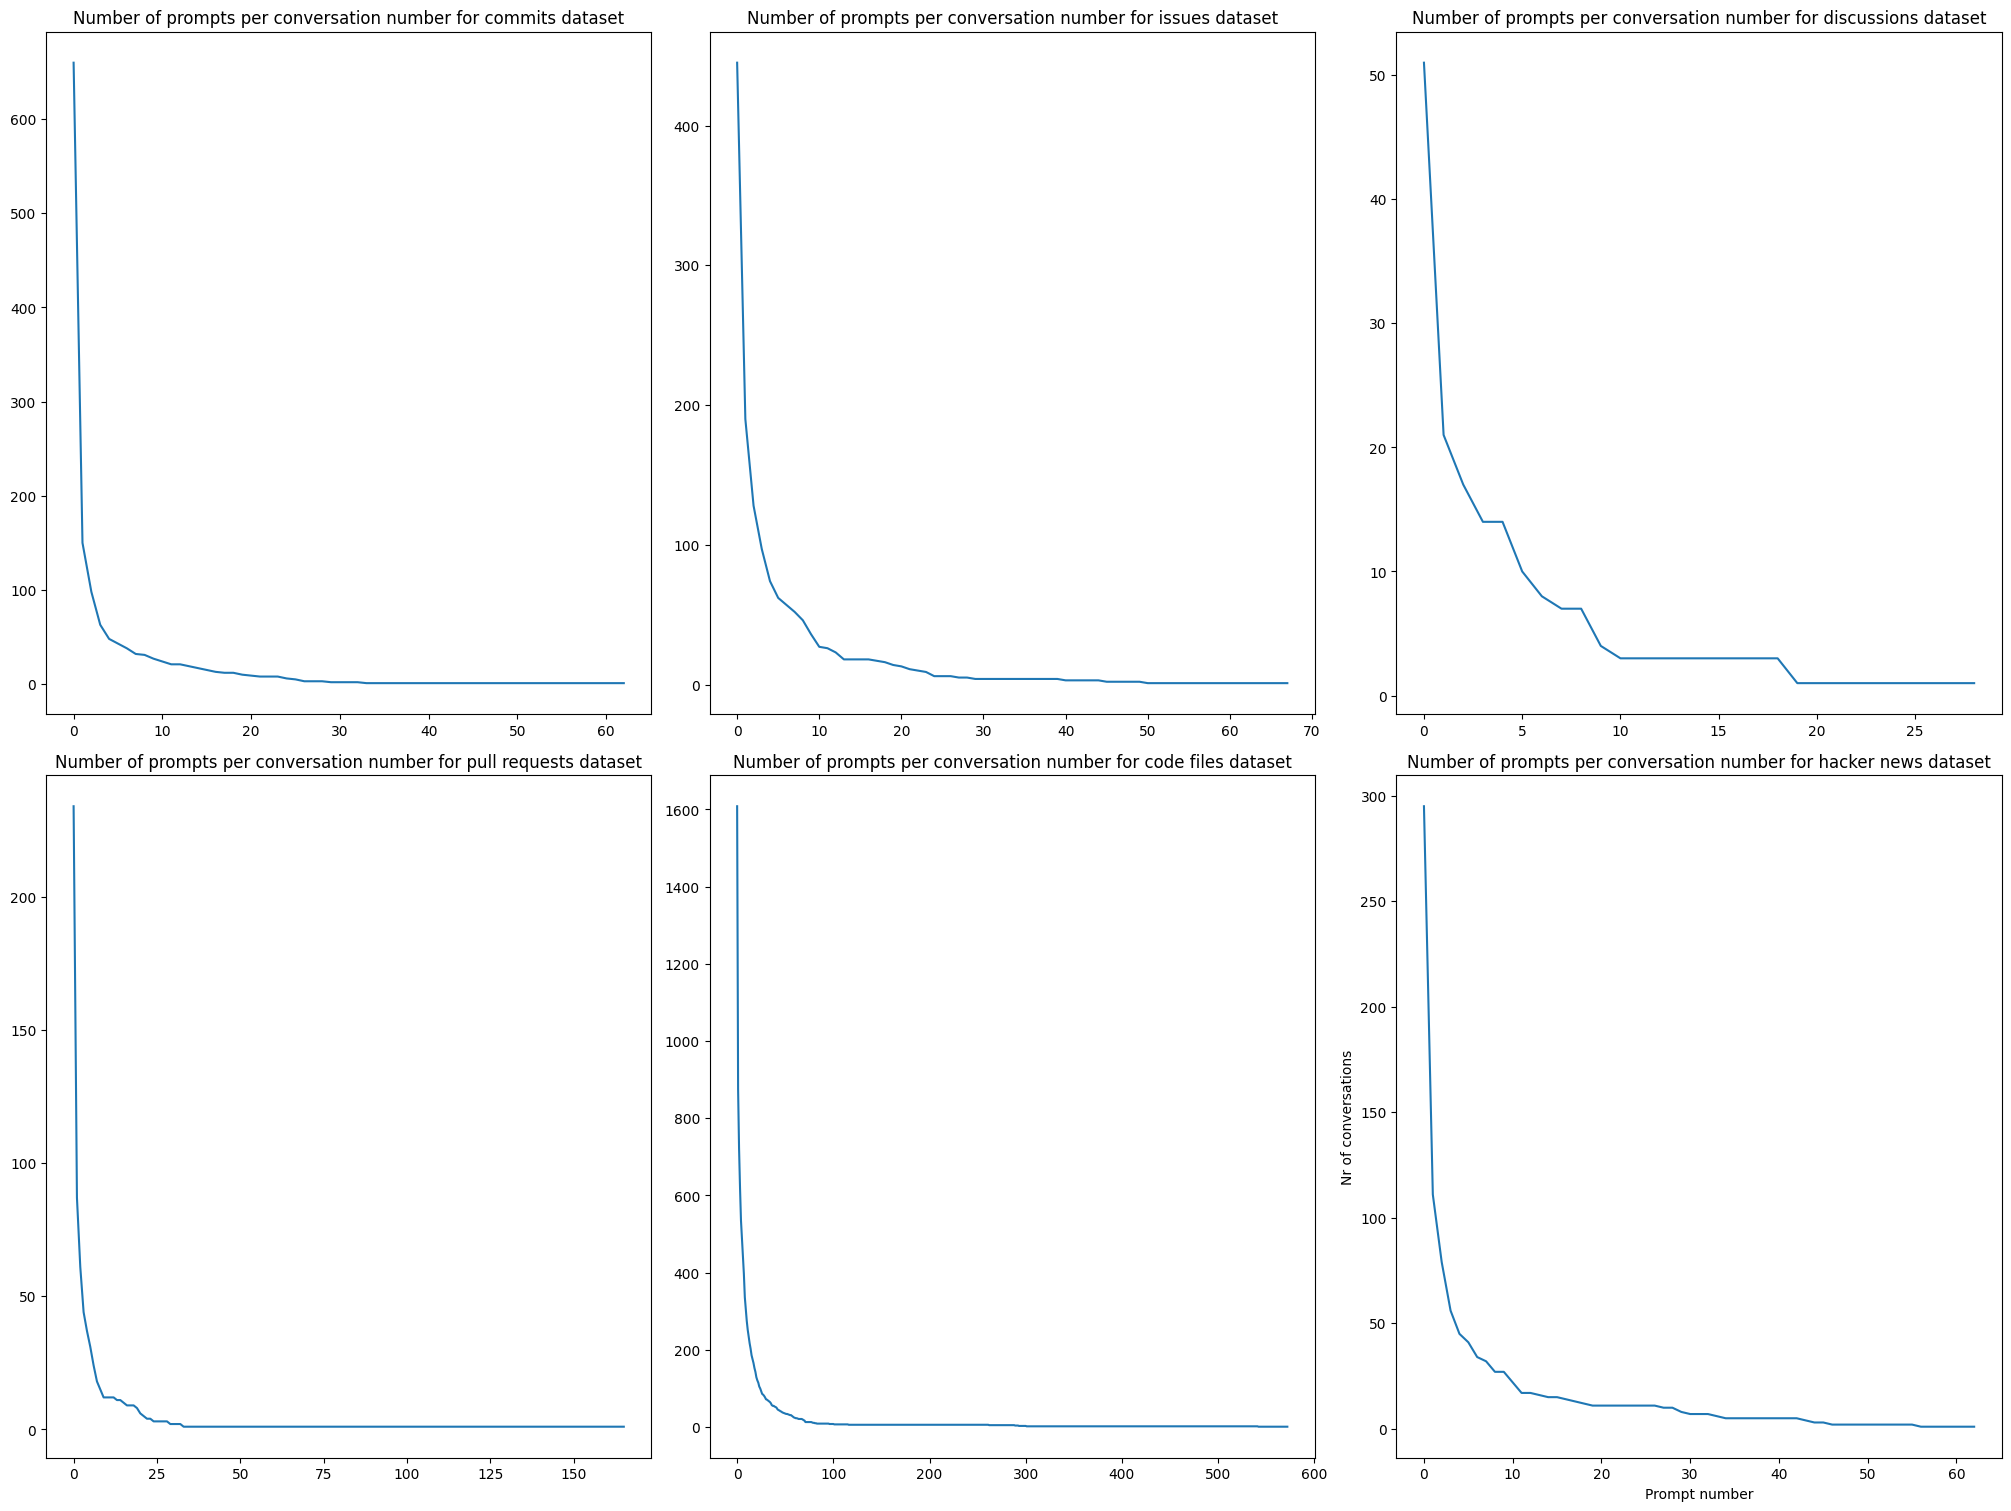

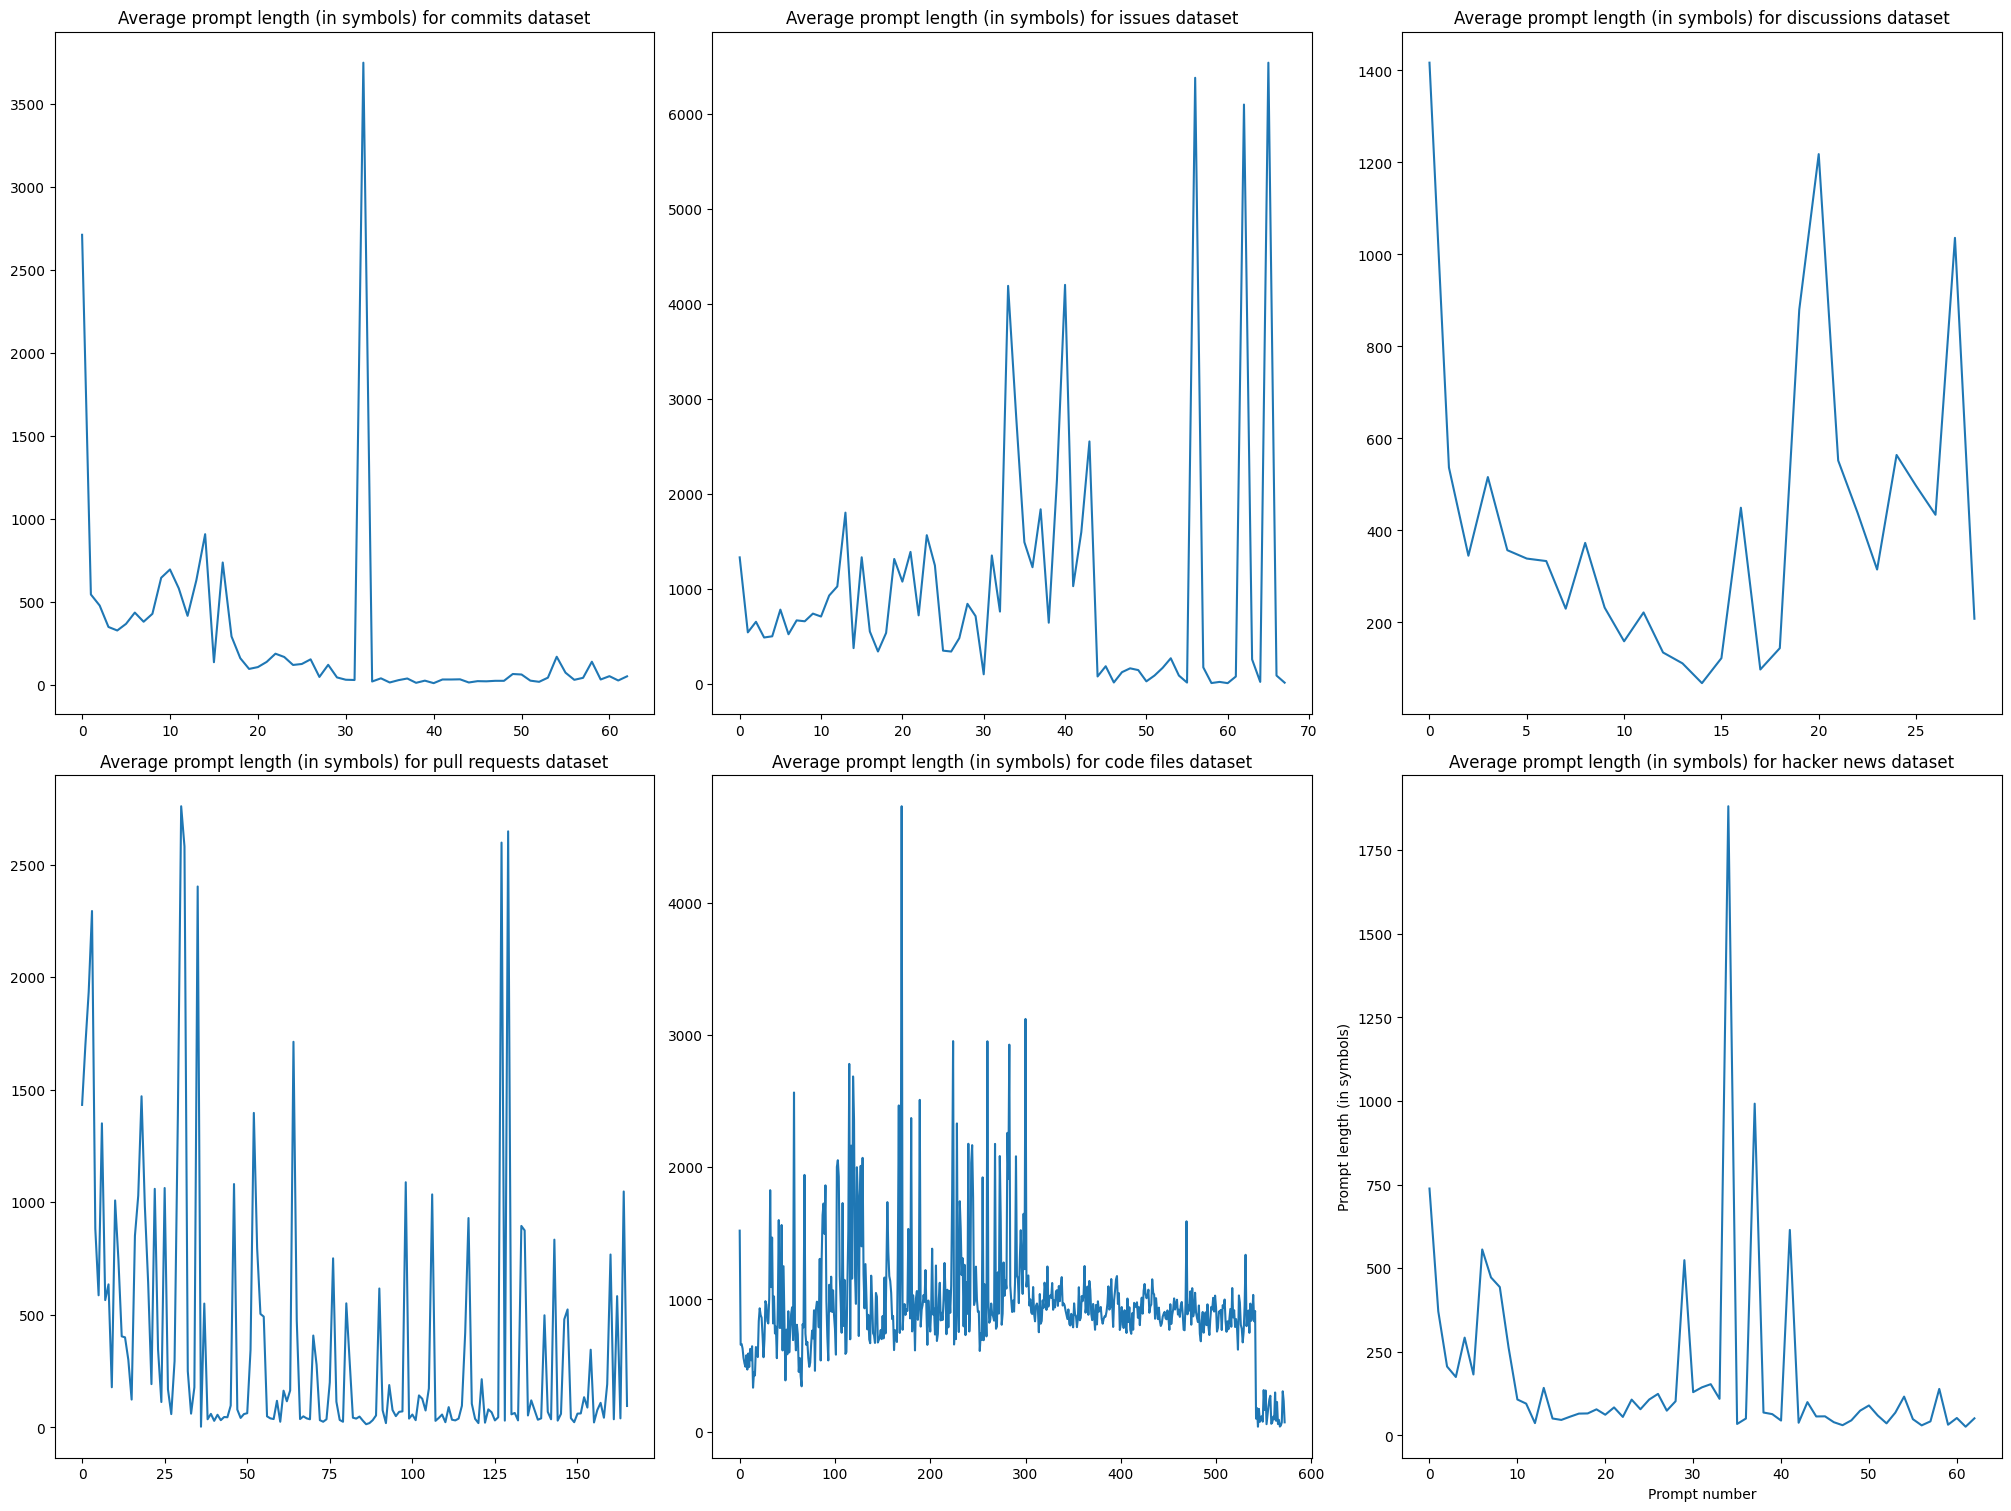

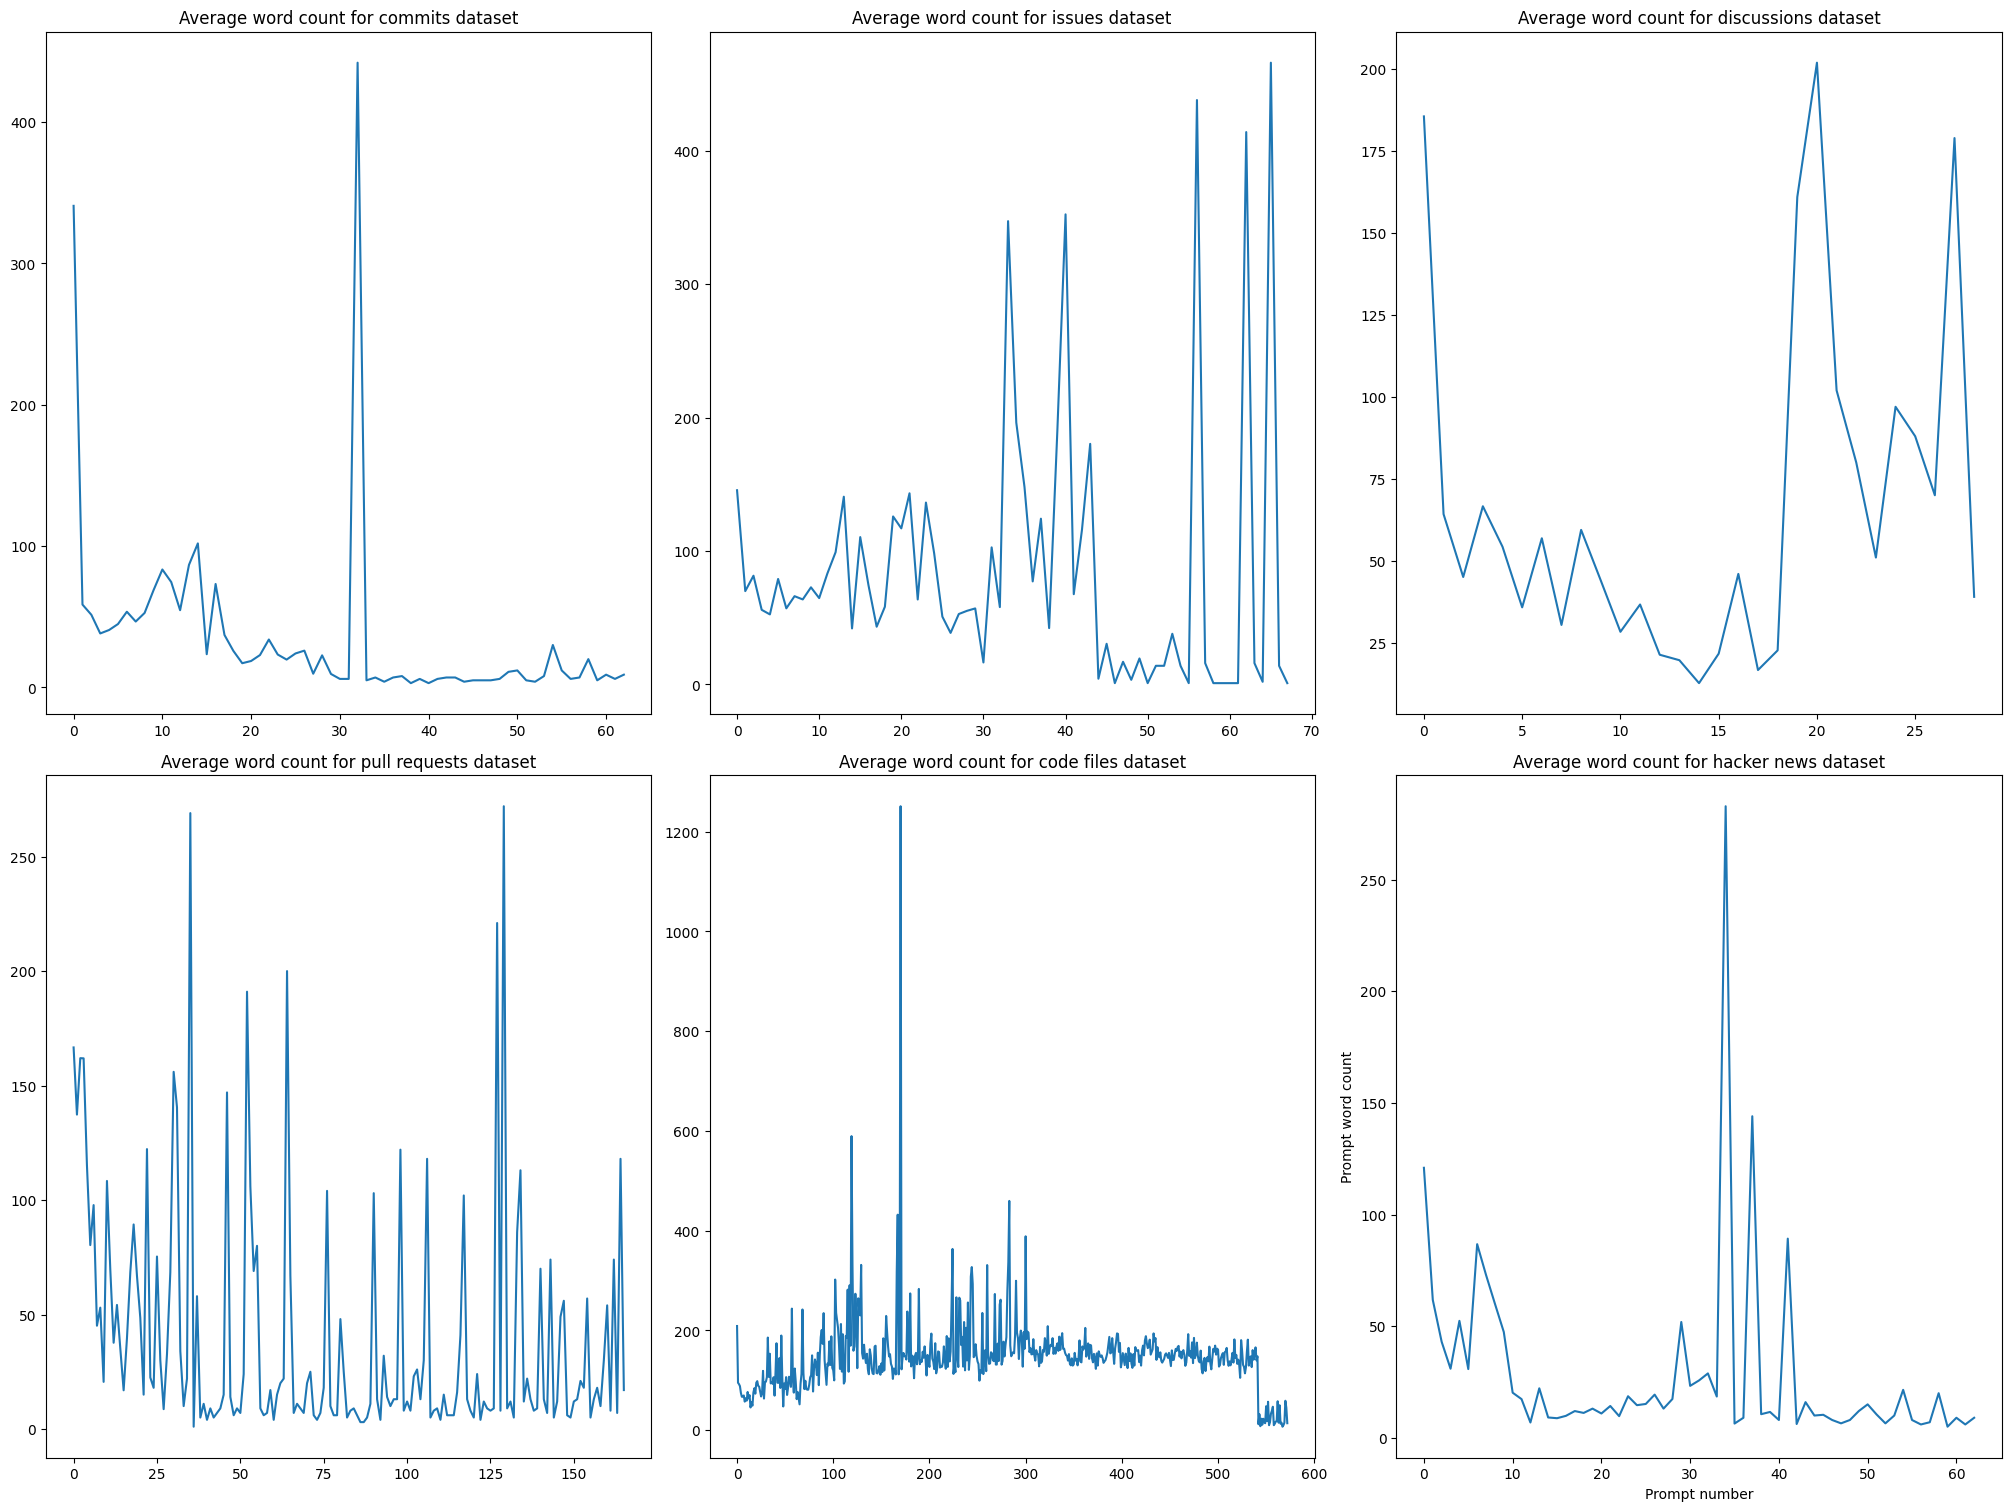

In [76]:
stats = [conversation_count_per_conv_nr, avg_prompt_lengths, avg_prompt_word_count]
stats_titles = ["Number of prompts per conversation number", "Average prompt length (in symbols)", "Average word count"]
stats_ylabels = ["Nr of conversations", "Prompt length (in symbols)", "Prompt word count"]

assert(len(stats) == len(stats_titles) == len(stats_ylabels))

for stat_idx, stat in enumerate(stats):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15), layout="constrained")
    plt.xlabel("Prompt number")
    plt.ylabel(f'{stats_ylabels[stat_idx]}')
    for idx in range(len(dataframes)):
        i,j = int(not(idx<3)),idx % 3
        axs[i,j].set_title(f'{stats_titles[stat_idx]} for {dataframe_names[idx]} dataset')
        axs[i,j].plot(stat[idx])
        
    
    plt.show()

In [126]:
def tokenize_all_prompts(prompts):
    all_tokens = []
    for prompt in prompts:
        tokens = [word for word in prompt if word not in stop_words]
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word.isalpha()]
        all_tokens.extend(tokens)
    return all_tokens

def prompts_ngrams(prompts, n):
    all_tokens = tokenize_all_prompts(prompts)
    bgs = nltk.ngrams(all_tokens, n)
    return nltk.FreqDist(bgs)

def plot_dist_as_cloud(prompts_ngrams, n, max_words):
    prob_dist = MLEProbDist(prompts_ngrams)
    visualisation_dict = {}
    for word_freq_tuple in prompts_ngrams:
        string = ' '.join(word_freq_tuple)
        visualisation_dict[string] = prob_dist.prob(word_freq_tuple)
    cloud = WordCloud(width=1000, height=500, max_words=max_words).generate_from_frequencies(visualisation_dict)
  
    plt.figure(figsize = (30,30))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print(f"Wordcloud for {n}-grams with the set max_words argument to {max_words}.")

def print_and_plot_ngrams(prompts_ngrams, n, dataframe_name, plot_cloud=True):
    print(f'Found {len(prompts_ngrams)} {n}-grams for {dataframe_name} dataframe. Most common 25 {n}-grams:')
    most_common_ngrams = prompts_ngrams.most_common(25)
    for word_freq_tuple in most_common_ngrams:
      print(word_freq_tuple)
    if plot_cloud:
        plot_dist_as_cloud(prompts_ngrams, n, 50)

In [176]:
lemmatised_dataframes = []
prompts_dataframes = []

for df_idx in range(len(dataframes)):
    conv_prompts = []
    for index, df_row in dataframes[df_idx].iterrows():
        conversations = df_row["Conversations"]
        for conv in conversations:
            conv_prompts.append(conv["Prompt"])
    prompts_df = pd.DataFrame(conv_prompts, columns=["Prompts"])
    prompts_dataframes.append(prompts_df)
    prompts_df["Prompts"] = prompts_df["Prompts"].map(lambda x: lemmatize_sentence(x))
    lemmatised_dataframes.append(prompts_df)

In [178]:
n = 3
for idx, df in enumerate(lemmatised_dataframes):
    all_ngrams_frequencies = prompts_ngrams(df["Prompts"], n)
    print_and_plot_ngrams(all_ngrams_frequencies, n, dataframe_names[idx])

# Topic modelling

In [208]:
wpt = nltk.WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokeanize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

def process_reviews_into_dictionary_and_corpus(reviews_ngram_data, n):
    if n > 1:
        reviews_ngram_data = [("_".join(reviews_tuple),) for reviews_tuple in reviews_ngram_data]
        dictionary = corpora.Dictionary(reviews_ngram_data)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_ngram_data]
    elif n == 1:
        dictionary = corpora.Dictionary(reviews_ngram_data)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_ngram_data]
    else:
        raise Exception('n should be positive integer')
    return dictionary, doc_term_matrix

def topic_modelling_visualisation(top_n, topics_dicts, dataset_name, enumeration):
    cols = [color for _, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=top_n,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

    
    fig, axs = plt.subplots(2,math.ceil(len(topics_dicts)/2), figsize=(15,10))
    axs = axs.ravel()
    for i in range(len(topics_dicts)):
        cloud.generate_from_frequencies(topics_dicts[i], max_font_size=300)
        axs[i].imshow(cloud)
        axs[i].set_title('Topic ' + str(i), fontdict=dict(size=16))
        axs[i].axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    print(f"Figure {enumeration}: Topic modelling for {dataset_name} dataset\n")

# Code source: https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/topic-modeling-naive.html#topic=0&lambda=1&term=

def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    for i, topic_weights in enumerate(tw_m):  ## for each topic row
        topic = [(token, np.round(weight, 2))
                 for token, weight in zip(vocab, topic_weights)
                 ]  ## zip (word, importance_weight)
        topic = sorted(topic,
                       key=lambda x: -x[1])  ## rank words according to weights
        topic_topn = topic[:topn]
        if display_weights:
            topic = [item for item in topic_topn if item[1] > weight_cutoff
                     ]  ## output words whose weights > 0.6
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

-----------------------------------------------------------------------
Topic modelling for commits.
Topic #0 :
[('const', 186.71), ('new', 142.47), ('user', 139.23), ('pick', 109.51), ('var', 99.54), ('import', 97.35), ('return', 86.61), ('rikishi', 82.17), ('document', 80.66), ('value', 78.1)]
Topic #1 :
[('file', 1979.24), ('import', 1753.75), ('task', 1413.82), ('const', 1259.44), ('set', 741.49), ('echo', 727.72), ('example', 680.51), ('export', 674.15), ('working', 597.97), ('script', 583.67)]
Topic #2 :
[('file', 251.55), ('prompt', 230.14), ('const', 210.88), ('task', 191.59), ('junior', 188.03), ('ai', 165.39), ('project', 161.66), ('use', 128.31), ('34', 118.13), ('code', 104.78)]
Topic #3 :
[('pm2', 199.46), ('mindful', 123.17), ('ai', 122.01), ('name', 104.8), ('mindful ai', 67.17), ('0mindful ai', 66.16), ('0mindful', 63.21), ('log', 61.88), ('app mindful', 61.17), ('app', 60.26)]
Topic #4 :
[('file', 732.7), ('task', 549.7), ('import', 548.57), ('const', 468.2), ('prompt'

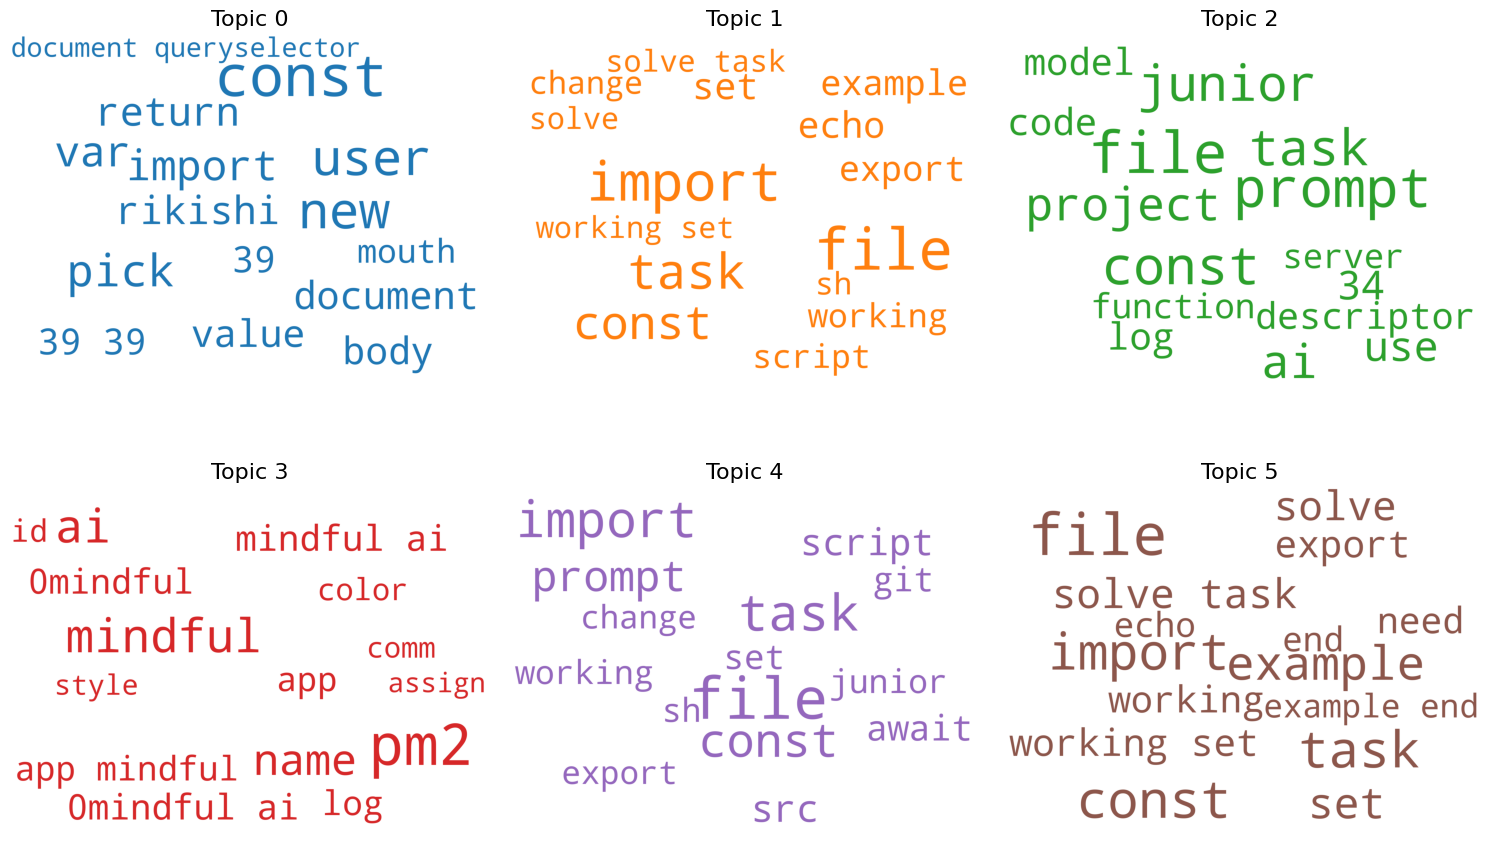

Figure 0: Topic modelling for commits dataset

Model coherence score: nan
Model perplexity: 64238.9977
-----------------------------------------------------------------------
Topic modelling for issues.
Topic #0 :
[('none', 326.65), ('else', 160.12), ('div', 139.69), ('self', 119.95), ('use_cache', 115.77), ('def', 114.07), ('inputs_embeds', 104.74), ('return', 101.97), ('hidden_states', 101.5), ('file', 99.77)]
Topic #1 :
[('file', 157.11), ('line', 151.65), ('model', 131.94), ('hoeveler', 126.17), ('http', 124.8), ('com', 114.17), ('http www', 109.13), ('www', 109.12), ('hoeveler com', 101.17), ('www hoeveler', 101.17)]
Topic #2 :
[('let', 114.18), ('file', 113.38), ('iob', 105.17), ('line', 98.8), ('idx', 95.17), ('corefiobtags', 90.17), ('lib', 75.25), ('build', 73.06), ('ents', 72.17), ('py', 68.69)]
Topic #3 :
[('gradle', 192.17), ('java', 189.08), ('return', 178.01), ('org', 175.06), ('org gradle', 174.17), ('internal', 174.07), ('const', 166.1), ('get', 130.34), ('gradle intern

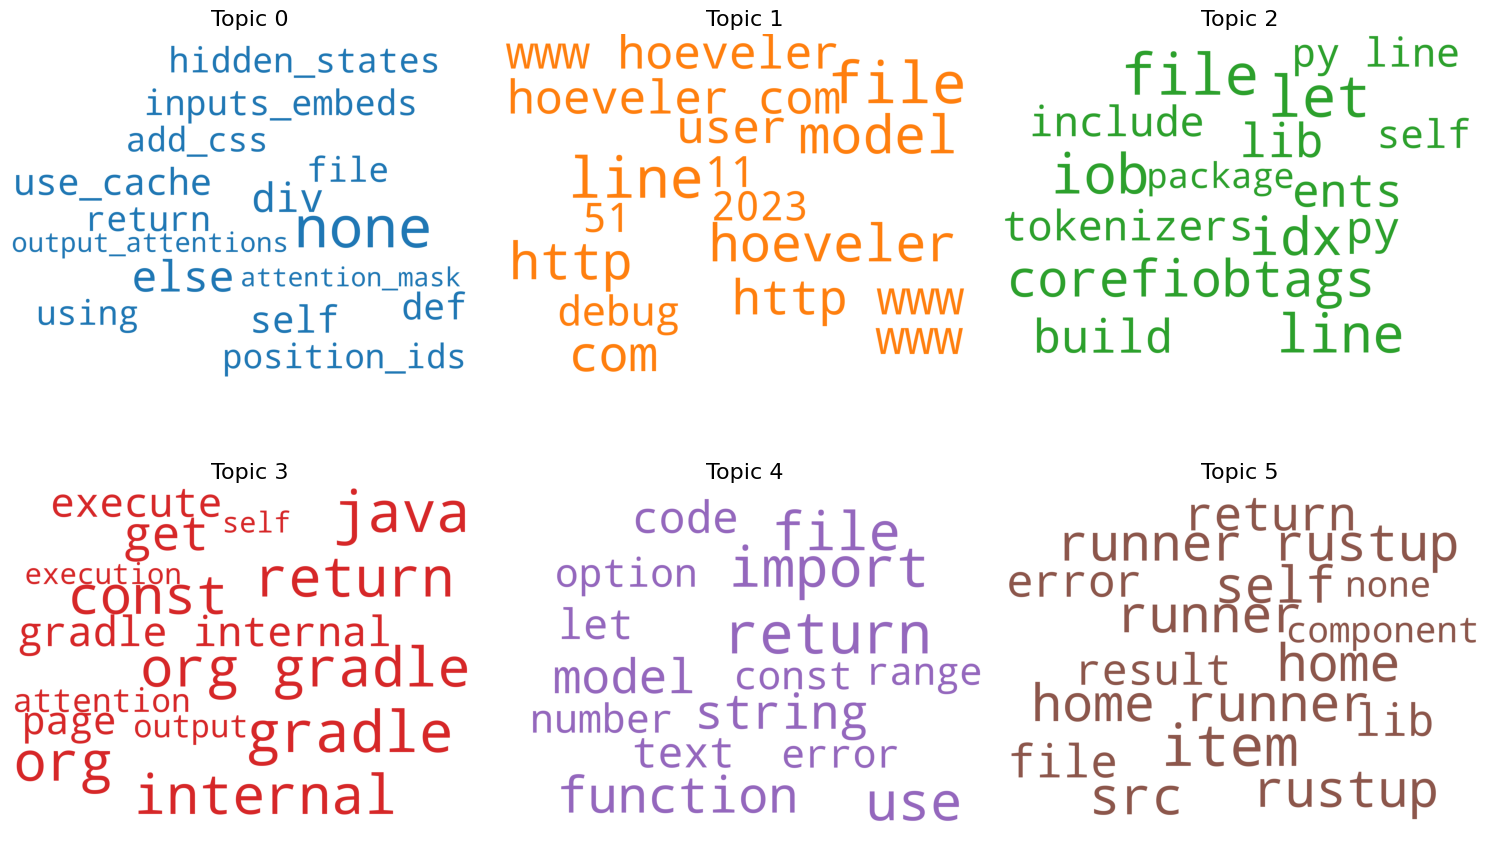

Figure 1: Topic modelling for issues dataset

Model coherence score: nan
Model perplexity: 9040753.9261
-----------------------------------------------------------------------
Topic modelling for discussions.
Topic #0 :
[('model', 55.01), ('data', 37.17), ('bayesian', 22.17), ('pad', 20.17)]
Topic #1 :
[('self', 48.17), ('say', 46.17), ('action', 41.17), ('message', 39.17), ('return', 34.17), ('method', 27.17), ('none', 25.17), ('student', 24.17), ('id', 22.17), ('code', 21.17)]
Topic #2 :
[]
Topic #3 :
[('would', 25.96)]
Topic #4 :
[('error', 35.17), ('puppeteer', 31.17), ('new', 21.17)]
Topic #5 :
[('step', 26.17), ('yes', 23.17), ('using', 20.02)]


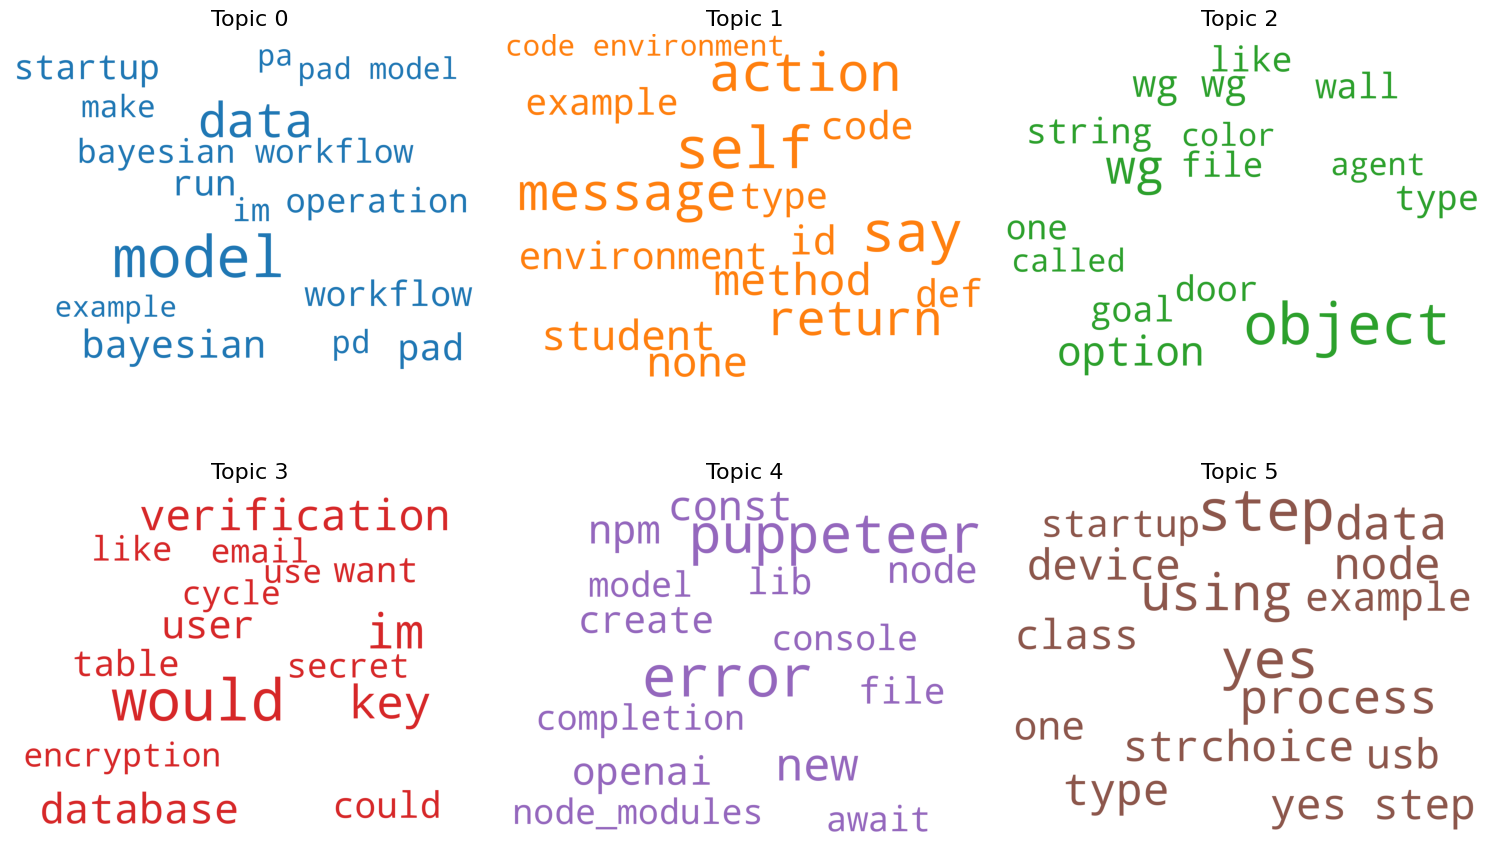

Figure 2: Topic modelling for discussions dataset

Model coherence score: nan
Model perplexity: 19284833.7482
-----------------------------------------------------------------------
Topic modelling for pull requests.
Topic #0 :
[('subclassof', 132.17), ('cavity', 71.17), ('entity', 68.17), ('const', 54.49), ('part', 52.91), ('cavity lumen', 48.17), ('coelemic', 48.17), ('coelemic cavity', 48.17), ('lumen', 48.17), ('cell', 47.17)]
Topic #1 :
[('const', 254.21), ('int', 130.17), ('sum', 106.17), ('netdata', 98.17), ('device', 95.17), ('float', 94.17), ('device const', 87.17), ('39', 85.17), ('const int', 82.17), ('constant', 79.17)]
Topic #2 :
[('service', 77.56), ('company', 72.17), ('use', 48.81), ('information', 46.17), ('stringarray', 42.57), ('coin', 38.17), ('pthe', 36.17), ('tx', 36.17), ('result', 34.17), ('comment', 33.17)]
Topic #3 :
[('user', 147.71), ('const', 133.63), ('pick', 91.01), ('true', 82.96), ('description', 74.29), ('result', 69.41), ('rikishi', 68.09), ('var', 68

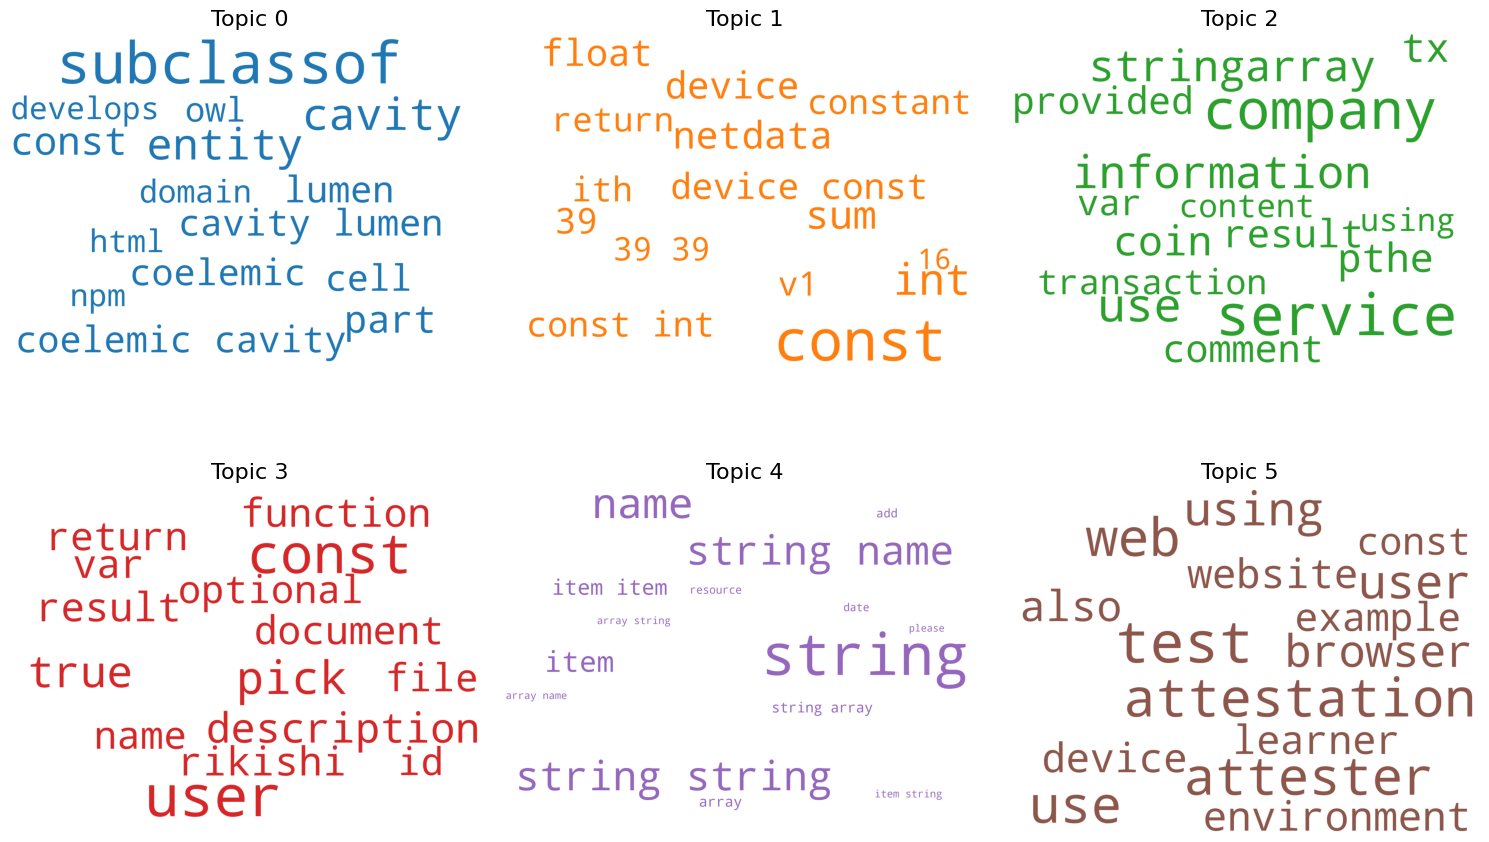

Figure 3: Topic modelling for pull requests dataset

Model coherence score: nan
Model perplexity: 442803.0148
-----------------------------------------------------------------------
Topic modelling for code files.
Topic #0 :
[('actor', 957.84), ('workshop', 954.76), ('data', 824.85), ('student', 736.84), ('work', 498.01), ('feedback', 443.3), ('quality', 441.73), ('time', 425.59), ('interaction', 422.69), ('step', 409.85)]
Topic #1 :
[('state', 2963.48), ('value', 1781.84), ('self', 1408.35), ('return', 1305.7), ('action', 1033.31), ('node', 990.68), ('def', 896.57), ('type', 853.76), ('function', 841.69), ('file', 704.21)]
Topic #2 :
[('passage', 4019.16), ('subversion', 1546.17), ('expectation', 1484.81), ('reference', 1408.67), ('break', 1375.37), ('subversion expectation', 1367.17), ('upon', 1306.14), ('like', 1282.86), ('face', 1167.48), ('voice', 1038.58)]
Topic #3 :
[('say', 1731.22), ('user', 689.42), ('new', 681.63), ('case', 679.47), ('begin', 660.92), ('end', 648.36), ('let'

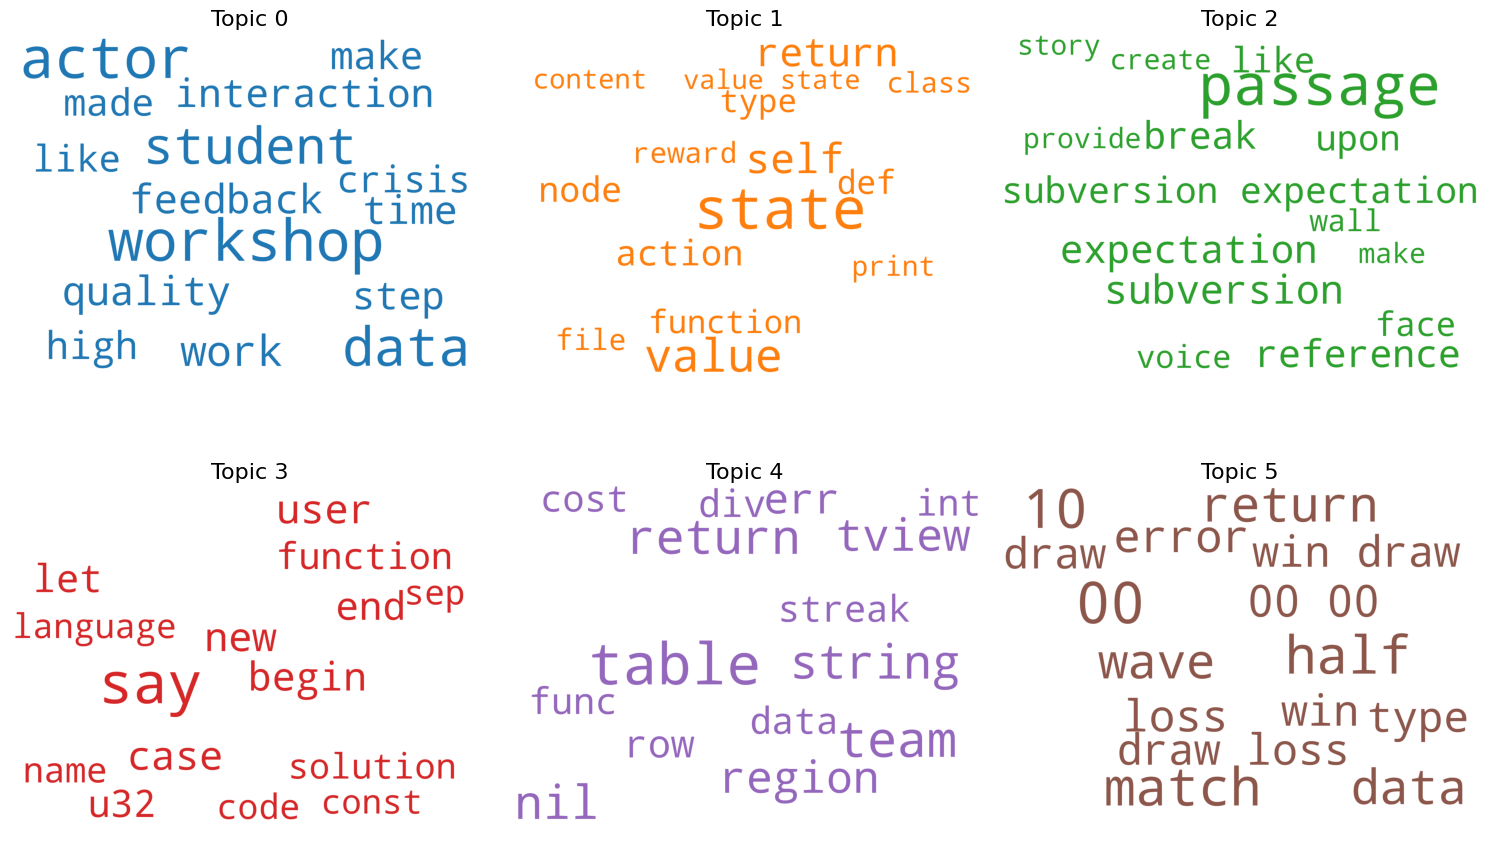

Figure 4: Topic modelling for code files dataset

Model coherence score: 0.6387
Model perplexity: 1750669.9791
-----------------------------------------------------------------------
Topic modelling for hacker news.
Topic #0 :
[('medical', 40.17), ('death', 35.17), ('error', 35.17), ('medical error', 27.17), ('would', 27.17), ('like', 26.16), ('study', 25.17), ('one', 24.31), ('please', 20.13)]
Topic #1 :
[('value', 132.17), ('track', 113.17), ('example', 79.17), ('example value', 68.17), ('time', 41.16), ('number', 38.17), ('like', 36.67), ('float', 36.17), ('number float', 36.17), ('10', 36.13)]
Topic #2 :
[('english', 42.17), ('litechain', 41.17), ('like', 37.13), ('image', 35.01), ('chain', 33.17), ('metal', 31.17), ('death', 27.17), ('death metal', 27.17), ('metal english', 24.17), ('text', 20.27)]
Topic #3 :
[('letter', 33.14), ('one', 32.78), ('word', 29.71), ('mind', 27.17), ('self', 26.17), ('time', 26.17), ('could', 20.08)]
Topic #4 :
[('cold', 342.16), ('headline', 162.05), 

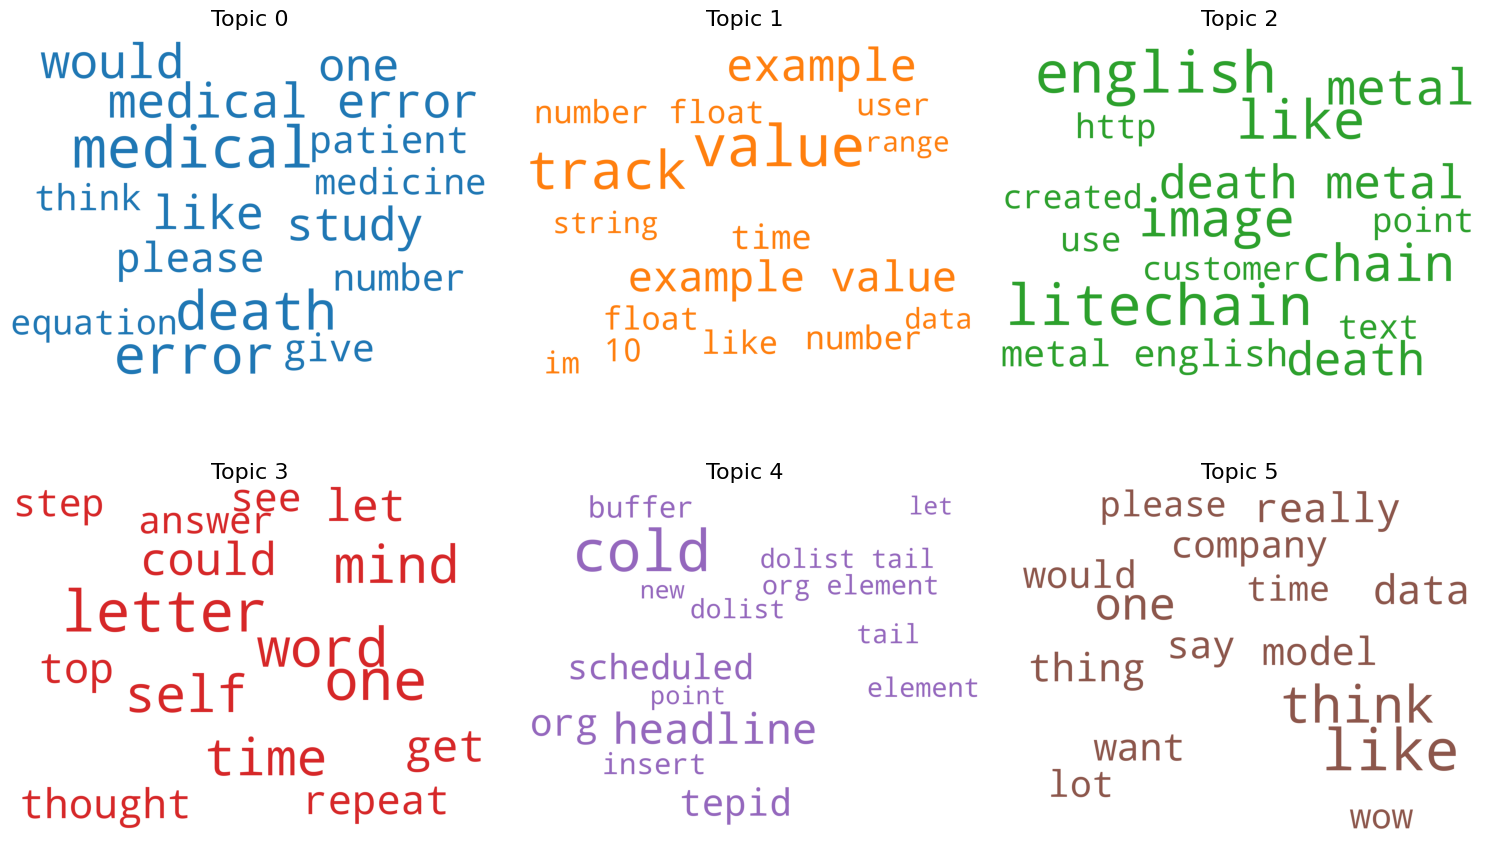

Figure 5: Topic modelling for hacker news dataset

Model coherence score: nan
Model perplexity: 10156726.7562


In [214]:
random_state = 42
n_topics = 6
max_iterations = 10

for i, df in enumerate(prompts_dataframes):
    # Normalise prompts
    normalize_corpus = np.vectorize(normalize_document)
    norm_corpus = normalize_corpus(df).flatten()

    # Transform corpus data into bag-of-words count matrix representation
    # Rows of the matrix represent the document, while columns are the vocabulary tokens
    cv = CountVectorizer(min_df=0., max_df=1., ngram_range = (1,2), stop_words=stop_words)
    cv_matrix = cv.fit_transform(norm_corpus)
    X_train, X_test = train_test_split(cv_matrix, train_size=0.8, test_size=0.2, shuffle=True, random_state=random_state)
    vocabulary = cv.get_feature_names_out()

    # LDA modelling
    LDA_model = LatentDirichletAllocation(n_components=n_topics,
                                            max_iter=max_iterations,
                                            random_state=random_state)
    LDA_model.fit(X_train)
    LDA_model.transform(X_test)

    #Coherence score calculation
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=LDA_model.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names_out()),
            texts=norm_corpus_tokens)

    # Visualisation
    print(f"-----------------------------------------------------------------------\nTopic modelling for {dataframe_names[i]}.")
    #pyLDAvis.lda_model.prepare(LDA_model, cv_matrix, cv, mds='mmds')
    topics_dicts = []
    for index, topic in enumerate(LDA_model.components_):
        #print(f'Top-{n_top_words_per_topic} for topic #{index}: {[cv.get_feature_names_out()[i] for i in topic.argsort()[-n_top_words_per_topic:]]}')
        topic_weights = [(token, np.round(weight, 2))
                         for token, weight in zip(vocabulary, topic)
                         ]  ## zip (word, importance_weight)
        topic_weights = sorted(topic_weights, key=lambda x: -x[1]) 
        word_weights = {}
        for weight in topic_weights:
            word_weights[weight[0]] = weight[1]
        topics_dicts.append(word_weights)
    get_topics_meanings(LDA_model.components_, vocabulary, display_weights=True, topn=10, weight_cutoff=20)
    topic_modelling_visualisation(n_top_words_per_topic, topics_dicts, dataframe_names[i], i)
    print(f'Model coherence score: {"%.4f" % np.mean(cur_coherence_score)}')
    print(f'Model perplexity: {"%.4f" % LDA_model.perplexity(X_test)}')